In [1]:
import numpy as np
import pickle
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Audio
from IPython.display import display
from scipy.io import wavfile
from itertools import chain 
import string
import Levenshtein as Lev
from itertools import groupby
import scipy.stats as st
from scipy import signal
import nltk
from scipy.stats import wasserstein_distance as wd
from sklearn.metrics.pairwise import euclidean_distances as ed
from pyemd import emd
from hyphenate import hyphenate_word
from itertools import islice 
from collections import OrderedDict

### Set up dataframe for transcripts and files

In [2]:
df_trans = pd.read_csv('my_data/all_overlap.txt', delimiter = " : ", header = None, names = ['file', 'transcript'])
df_trans['file'] = df_trans['file'].map(lambda x: x.split('.')[0])
print(df_trans.head(20))

len(df_trans)

                        file  \
0     common_voice_en_633986   
1   common_voice_en_17285933   
2     common_voice_en_540956   
3   common_voice_en_17297426   
4     common_voice_en_177712   
5   common_voice_en_17256256   
6     common_voice_en_102956   
7     common_voice_en_645402   
8     common_voice_en_109017   
9     common_voice_en_198426   
10    common_voice_en_607196   
11     common_voice_en_99415   
12    common_voice_en_169428   
13    common_voice_en_169429   
14     common_voice_en_13691   
15  common_voice_en_17252286   
16    common_voice_en_504873   
17    common_voice_en_504874   
18    common_voice_en_615767   
19  common_voice_en_17772045   

                                           transcript  
0   That night, there was another jetting out of g...  
1        Would anyone care for some lavender custard?  
2                                  I'm going to them.  
3                  In another year, maybe I can help.  
4   Absolutely despicable that gingerbread men 

/home/archiki/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


2674

In [3]:
with open('my_data/common-final-file-info.json', 'r') as j:
	file_meta = json.load(j)

In [4]:
transcripts = list(set(df_trans['transcript'].tolist()))
len(transcripts)

382

In [5]:
trans_dict = {x:[] for x in transcripts}

In [6]:
for index, row in df_trans.iterrows():
    trans_dict[row['transcript']].append(row['file'])
    

In [7]:
trans_dict["I'm going to them."]

['common_voice_en_540956',
 'common_voice_en_524507',
 'common_voice_en_179645',
 'common_voice_en_110121',
 'common_voice_en_171907',
 'common_voice_en_214487',
 'common_voice_en_217235']

In [8]:
file_meta['common_voice_en_633986']['accent']
print(df_trans[df_trans['file'] == 'common_voice_en_633986'].transcript.values)


['That night, there was another jetting out of gas from the distant planet.']


##### Normalize Attributions 

In [9]:
def get_norm_attr(index_dict):
    norm_dict = {}
    for key in index_dict.keys():
        norm_dict[key] = index_dict[key]/np.sum(index_dict[key])
        np.set_printoptions(precision=4)
        #print(norm_dict[key])
        #break
    return norm_dict

##### Fetching frame allignmnets from the meta-data (using gentle)

In [10]:
def get_frame_allignment(file, input_size):
    alligned = []
    spec_stride = 0.01
    window_size = 0.02
    times = file_meta[file]['end_times']
    last_idx = 0
    for i in range(input_size):
        frame_idx = i
        window_start = frame_idx*spec_stride
        window_mid = window_start + (window_size/2)
        alligned_phone = 'na'
        for j in range(len(times)):
            if (window_mid < times[j]):
                alligned_phone = file_meta[file]['phones'][j]
                break
        #assert alligned_phone != 'na', "Failed to fetch allignment"
        if(alligned_phone != 'na'):
            alligned.append(alligned_phone)
            last_idx = i
    pause_start = 0
    pause_end = len(alligned)
    for i in range(len(alligned)):
        if(alligned[i] != 'pause'):
            break
        pause_start = i
    
    for i in range(len(alligned)-1,-1,-1):
        if(alligned[i] != 'pause'):
            break
        pause_end = i
        
    #print(last_idx)
    #print(pause_start, pause_end)
    return alligned, pause_start +1, pause_end
    

###  Visualizing (signed) attributions 

_A_ ANY _ME_I_N_ TO_ THE_M_ england
[1, 3, 4, 5, 6, 7, 9, 10, 12, 14, 16, 17, 18, 20, 21, 22, 23, 25]
for A


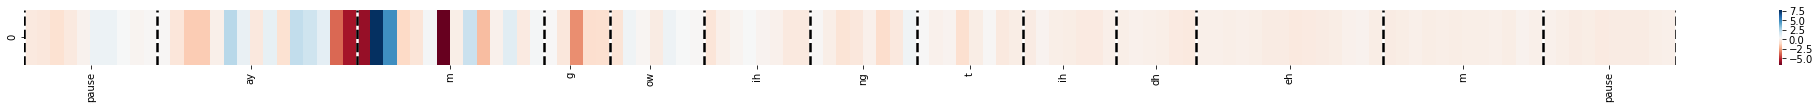

_I_N_ DO_I_N_ TO_ _M_ scotland
[1, 3, 5, 6, 7, 9, 11, 13, 14, 15, 17, 19]
for I


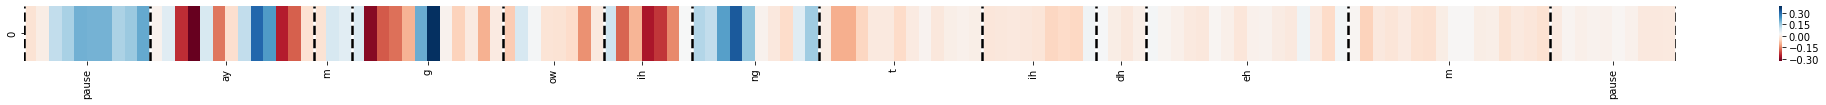

_I'M GOING TO_ THE_M_ canada
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 19]
for I


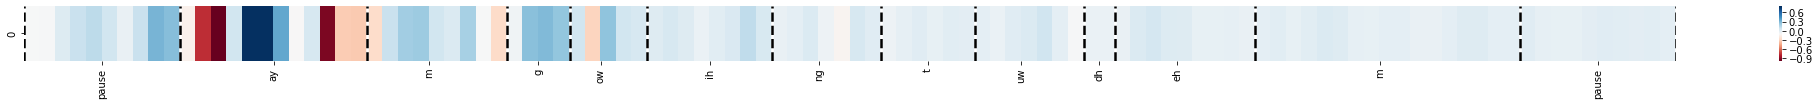

_I_'ND GO_ING TO_ THE_M_ australia
[1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 22]
for I


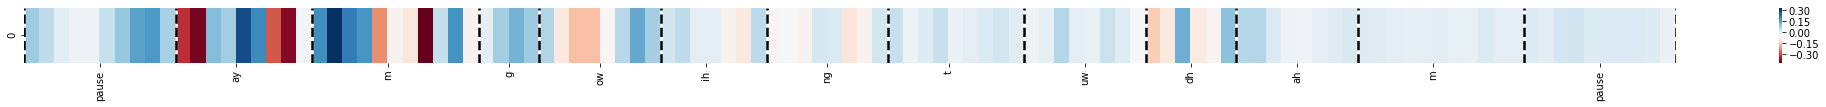

_I_'M_ GWO_MED_O_ THE_M_ indian
[1, 3, 4, 6, 7, 8, 9, 11, 12, 13, 15, 17, 18, 19, 20, 22]
for I


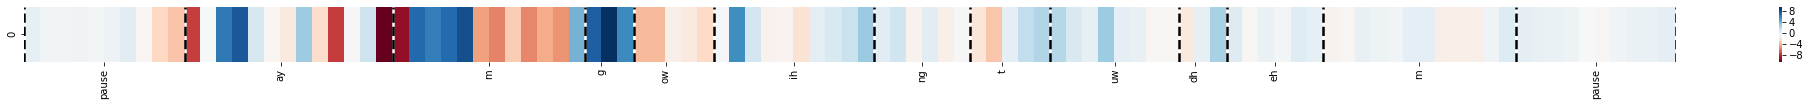

_I_'M_ GO_ING_ TO_ THE_M_ african
[1, 3, 4, 6, 7, 8, 10, 11, 12, 14, 15, 16, 18, 19, 20, 21, 23]
for I


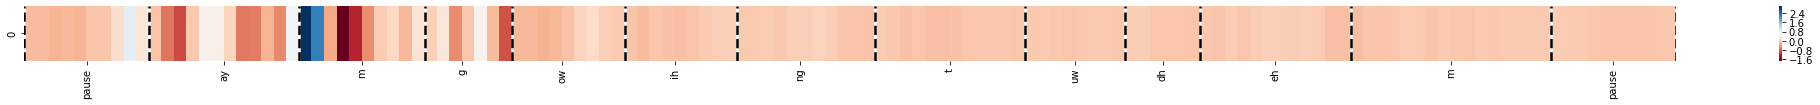

_I_'M_ GO_ING TO_ THE_M_ us
[1, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 22]
for I


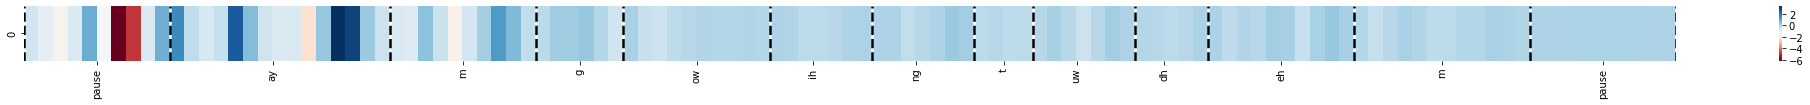

In [35]:
for file in trans_dict["I'm going to them."]:
    try:
        #file = 'common_voice_en_110121'
        Fs, wav = wavfile.read('my_data/MCV_validated_{}/wav/{}.wav'.format(file_meta[file]['accent'],file))
        display(Audio(wav, rate=Fs))
        with open('attribution/grad/{}.pickle'.format(file), 'rb') as j:
            file_attr = pickle.load(j)
        print(file_attr['output'], file_meta[file]['accent'])
        print(list(file_attr['attr dict'].keys()))
        normalized_attr = get_norm_attr(file_attr['attr dict'])
        keys = list(normalized_attr.keys())
        input_size = len(file_attr['attr dict'][list(file_attr['attr dict'].keys())[0]]) # calculate properly once
        buffer = 10
    #print(get_frame_allignment(file,input_size))
    #     with np.printoptions(precision=4, suppress=True):
    #         print(normalized_attr[1][:291])
        plot_vertical = False
        idx = 0
        if(plot_vertical):
            fig = plt.figure(figsize = (1,35))
            print(get_frame_allignment(file, input_size))
            allignments, p_start, p_end = get_frame_allignment(file, input_size)
            allignments = np.asarray(allignments)            
            actual_size = len(allignments)
            sns.heatmap(np.expand_dims(normalized_attr[1][:actual_size], axis = 1),annot = np.expand_dims(allignments, axis = 1), fmt="", cmap='RdBu')
            #plt.yticks(rotation=) 
            #plt.yticks(range(allignments.shape[0]),list(allignments))
            plt.show()
        else:
            
            fig = plt.figure(figsize = (37,1))
            allignments, p_start, p_end = get_frame_allignment(file, input_size)
            allignments = np.asarray(allignments)            
            actual_size = len(allignments)
            #actual_size = len(allignments)
            
            print('for',file_attr['output'][keys[idx]])
            sns.heatmap(np.expand_dims(normalized_attr[keys[idx]][p_start - buffer:p_end + buffer], axis = 0), fmt="", cmap='RdBu')
            #plt.yticks(rotation=) 
            modified_allignments = allignments[p_start - buffer:p_end + buffer]
            #phone_centres = []
            phone_labels = [x[0] for x in groupby(modified_allignments)]
            len_list = [len(list(x[1])) for x in groupby(modified_allignments)]
            idx_list = [0]
            ticks_list = []
            for l in len_list:
                ticks_list.append(idx_list[-1] + l//2)
                idx_list.append(idx_list[-1] + l)
                
           
            plt.xticks(ticks_list,phone_labels, rotation = 90)
            
            for j in idx_list:
                plt.axvline(x=j, color='w', linestyle='-', linewidth=2.5)
                plt.axvline(x=j, color='k', linestyle='--', linewidth=2.5)
                
                
                
            plt.show()
    #break
    except:
        print('failed for file : {}'.format(file))
        continue
    

### Visualizing (modulus/magnitude) attributions 

##### Generate **|*Input.Gradient*|** Attributution at grapheme-level

In [12]:
#for file in trans_dict["I'm going to them."]:
def inp_grad_grapheme(file, idx):
    try:
        #file = 'common_voice_en_110121'
#         Fs, wav = wavfile.read('my_data/MCV_validated_{}/wav/{}.wav'.format(file_meta[file]['accent'],file))
#         display(Audio(wav, rate=Fs))
        with open('attribution/grad/{}.pickle'.format(file), 'rb') as j:
            file_attr = pickle.load(j)
#         print(file_attr['output'], file_meta[file]['accent'])
#         print(list(file_attr['attr dict'].keys()))
        normalized_attr = get_norm_attr(file_attr['attr dict'])
        keys = list(normalized_attr.keys())
        input_size = len(file_attr['attr dict'][list(file_attr['attr dict'].keys())[0]]) # calculate properly once
        buffer = 10
    #print(get_frame_allignment(file,input_size))
    #     with np.printoptions(precision=4, suppress=True):
    #         print(normalized_attr[1][:291])
        plot_vertical = False
        #idx = 0
        
        if(plot_vertical):
            fig = plt.figure(figsize = (1,35))
            print(get_frame_allignment(file, input_size))
            allignments, p_start, p_end = get_frame_allignment(file, input_size)
            allignments = np.asarray(allignments)            
            actual_size = len(allignments)
            sns.heatmap(np.expand_dims(normalized_attr[1][:actual_size], axis = 1),annot = np.expand_dims(allignments, axis = 1), fmt="", cmap='RdBu')
            #plt.yticks(rotation=) 
            #plt.yticks(range(allignments.shape[0]),list(allignments))
            plt.show()
        else:
            
            fig = plt.figure(figsize = (37,1))
            #print(allignments)
            allignments, p_start, p_end = get_frame_allignment(file, input_size)
            allignments = np.asarray(allignments)            
            actual_size = len(allignments)
            #actual_size = len(allignments)
            
            print('for',file_attr['output'][keys[idx]])
            sns.heatmap(np.expand_dims(np.abs(normalized_attr[keys[idx]][p_start - buffer:p_end + buffer])/np.sum(np.abs(normalized_attr[keys[idx]][p_start - buffer:p_end + buffer])), axis = 0), fmt="", cmap='Blues')
            #plt.yticks(rotation=) 
            modified_allignments = allignments[p_start - buffer:p_end + buffer]
            phone_labels = [x[0] for x in groupby(modified_allignments)]
            len_list = [len(list(x[1])) for x in groupby(modified_allignments)]
            idx_list = [0]
            ticks_list = []
            for l in len_list:
                ticks_list.append(idx_list[-1] + l//2)
                idx_list.append(idx_list[-1] + l)
                
            #ticks_list.append((idx_list[-1] + len(modified_allignments))//2)   
            
            plt.xticks(ticks_list,phone_labels, rotation = 90)
            
            for j in idx_list:
                plt.axvline(x=j, color='w', linestyle='-', linewidth=2.5)
                plt.axvline(x=j, color='k', linestyle='--', linewidth=2.5)
            plt.show()
                
    #break
    except:
        print('failed for file : {}'.format(file))
        #continue
    

##### Helper functions for word-level allignments

In [13]:
def get_space(inp):
    spaces = []
    for idx, val in enumerate(inp):
        if(val == ' '): spaces.append(idx)
    return spaces

In [14]:
def get_words(test_list, split_list,spaces):
    temp = zip(chain([0], split_list), chain(split_list, [None])) 
    res = list(test_list[i : j] for i, j in temp) 
    #print(res)
    final_res = []
    for l in res:
        if(l[0] in spaces):
            final_res.append([l[0]])
            final_res.append(l[1:])
        else: 
            final_res.append(l)
    #print(final_res)
    return final_res

In [15]:
def get_words_wo_space(test_list, split_list,spaces):
    temp = zip(chain([0], split_list), chain(split_list, [None])) 
    res = list(test_list[i : j] for i, j in temp) 
    #print(res)
    final_res = []
    for l in res:
        if(l[0] in spaces):
            final_res.append([l[0]])
            final_res.append(l[1:])
        else: 
            final_res.append(l)
    #print(final_res)
    return final_res

##### Generate **|*Input.Gradient*|** Attributution at word-level 

In [16]:
#for file in trans_dict["I'm going to them."]:
def inp_grad_word(file, word_idx):
    try:
    #file = 'common_voice_en_110121'
    #print(file)
#         Fs, wav = wavfile.read('my_data/MCV_validated_{}/wav/{}.wav'.format(file_meta[file]['accent'],file))
#         display(Audio(wav, rate=Fs))
        with open('attribution/grad/{}.pickle'.format(file), 'rb') as j:
            file_attr = pickle.load(j)
#         print(file_attr['output'], file_meta[file]['accent'])

    #         print(file_attr['output'].split(' '))
        normalized_attr = get_norm_attr(file_attr['attr dict'])
        keys = list(normalized_attr.keys())
#         print(keys)
        spaces = get_space(file_attr['output'])
        indices = [keys.index(x) for x in spaces]
        words = get_words(keys,indices, spaces)
        input_size = len(file_attr['attr dict'][list(file_attr['attr dict'].keys())[0]]) # calculate properly once
        buffer = 10
        plot_vertical = False
        #word_idx = 0

        word_activation = np.sum(np.asarray([np.abs(normalized_attr[idx]) for idx in words[word_idx]] ), axis = 0)

        if(plot_vertical):
            fig = plt.figure(figsize = (1,35))
            print(get_frame_allignment(file, input_size))
            allignments, p_start, p_end = get_frame_allignment(file, input_size)
            allignments = np.asarray(allignments)            
            actual_size = len(allignments)
            sns.heatmap(np.expand_dims(normalized_attr[1][:actual_size], axis = 1),annot = np.expand_dims(allignments, axis = 1), fmt="", cmap='RdBu')

            plt.show()
        else:
            str_list = []
            for x in words[word_idx]:
                str_list.append(file_attr['output'][x])


            print(''.join(str_list))
            fig = plt.figure(figsize = (37,1))
            allignments, p_start, p_end = get_frame_allignment(file, input_size)
            allignments = np.asarray(allignments)            
            actual_size = len(allignments)
            #actual_size = len(allignments)

            sns.heatmap(np.expand_dims(word_activation[p_start - buffer:p_end + buffer]/np.sum(word_activation[p_start - buffer:p_end + buffer]), axis = 0), fmt="", cmap='Blues')
            #plt.yticks(rotation=) [p_start - buffer:p_end + buffer]
            modified_allignments = allignments[p_start - buffer:p_end + buffer]
            phone_labels = [x[0] for x in groupby(modified_allignments)]
            len_list = [len(list(x[1])) for x in groupby(modified_allignments)]
            idx_list = [0]
            ticks_list = []
            for l in len_list:
                ticks_list.append(idx_list[-1] + l//2)
                idx_list.append(idx_list[-1] + l)


            plt.xticks(ticks_list,phone_labels, rotation = 90)

            for j in idx_list:
                plt.axvline(x=j, color='w', linestyle='-', linewidth=2.5)
                plt.axvline(x=j, color='k', linestyle='--', linewidth=2.5)


            plt.show()
    
    except:
        print('failed for file : {}'.format(file))
#         continue
    

##### Helper functions to compare WERs

In [17]:
def wer(s1, s2):
        """
        Computes the Word Error Rate, defined as the edit distance between the
        two provided sentences after tokenizing to words.
        Arguments:
            s1 (string): space-separated sentence
            s2 (string): space-separated sentence
        """

        # build mapping of words to integers
        b = set(s1.split() + s2.split())
        word2char = dict(zip(b, range(len(b))))

        # map the words to a char array (Levenshtein packages only accepts
        # strings)
        w1 = [chr(word2char[w]) for w in s1.split()]
        w2 = [chr(word2char[w]) for w in s2.split()]

        return Lev.distance(''.join(w1), ''.join(w2))


In [18]:
transcript_wer = {}
#lm_wer = {}
accent_lm_wer = {x: [] for x in ['us', 'indian','african','canada','australia','england','scotland']}
accent_wer = {x: [] for x in ['us', 'indian','african','canada','australia','england','scotland']}

In [19]:
with open('wers.pickle', 'rb') as l:
    lm_wer = pickle.load(l)
    

In [20]:
for transcript in transcripts:
    transcript_ = transcript.strip().upper()
    wer_dict = {}

    valid_punctuation = string.punctuation.replace("'","")
    processed_transcript = transcript_.translate(str.maketrans({a:None for a in valid_punctuation }))
    #print(processed_transcript)       
    for file in trans_dict[transcript]:
        try:
            with open('attribution/{}.pickle'.format(file), 'rb') as j:
                file_attr = pickle.load(j)
            accent = file_meta[file]['accent']
            
            #print(accent)
            output = file_attr['output'].replace('_', '')
            #print(output)
            num_tokens = len(processed_transcript.split())
            wer_ = 100*wer(processed_transcript, output)/num_tokens
            wer_dict[accent] = wer_
            accent_wer[accent].append(wer_)
            accent_lm_wer[accent].append(lm_wer[file]['wer'])
            
        except:
            continue
        
    
    transcript_wer[transcript] = wer_dict

        

In [ ]:
print('accent','|', 'greedy','|', 'lm rescored','|', 'num of files')
for key in accent_wer.keys():
    print(key,'|', np.asarray(accent_wer[key]).mean(),'|', np.asarray(accent_lm_wer[key]).mean(),'|', len(accent_wer[key]))

In [22]:
#get_colour = {'us':'k', 'indian':'g','african':'b','canada':'r','australia':'c','england':'m','scotland':'y'}

##### Generate **|*Gradient*|** Attribution at grapheme-level

In [24]:
#for file in trans_dict["I'm going to them."]:
def grad_grapheme(file, idx):
    try:
        #file = 'common_voice_en_110121'
#         Fs, wav = wavfile.read('my_data/MCV_validated_{}/wav/{}.wav'.format(file_meta[file]['accent'],file))
#         display(Audio(wav, rate=Fs))
        with open('attribution/grad/{}.pickle'.format(file), 'rb') as j:
            file_attr = pickle.load(j)
#         print(file_attr['output'], file_meta[file]['accent'])
#         print(list(file_attr['grad_dict'].keys()))
        normalized_attr = get_norm_attr(file_attr['grad_dict'])
        keys = list(normalized_attr.keys())
        input_size = len(file_attr['grad_dict'][list(file_attr['grad_dict'].keys())[0]]) # calculate properly once
        buffer = 10
    #print(get_frame_allignment(file,input_size))
    #     with np.printoptions(precision=4, suppress=True):
    #         print(normalized_attr[1][:291])
        plot_vertical = False
        #idx = 0

        if(plot_vertical):
            fig = plt.figure(figsize = (1,35))
            print(get_frame_allignment(file, input_size))
            allignments, p_start, p_end = get_frame_allignment(file, input_size)
            allignments = np.asarray(allignments)            
            actual_size = len(allignments)
            sns.heatmap(np.expand_dims(normalized_attr[1][:actual_size], axis = 1),annot = np.expand_dims(allignments, axis = 1), fmt="", cmap='RdBu')
            #plt.yticks(rotation=) 
            #plt.yticks(range(allignments.shape[0]),list(allignments))
            plt.show()
        else:

            fig = plt.figure(figsize = (37,1))
            #print(allignments)
            allignments, p_start, p_end = get_frame_allignment(file, input_size)
            allignments = np.asarray(allignments)            
            actual_size = len(allignments)
            #actual_size = len(allignments)

            print('for',file_attr['output'][keys[idx]])
            sns.heatmap(np.expand_dims(np.abs(normalized_attr[keys[idx]][p_start - buffer:p_end + buffer])/np.sum(np.abs(normalized_attr[keys[idx]][p_start - buffer:p_end + buffer])), axis = 0), fmt="", cmap='Greens')
            #plt.yticks(rotation=) 
            modified_allignments = allignments[p_start - buffer:p_end + buffer]
            phone_labels = [x[0] for x in groupby(modified_allignments)]
            len_list = [len(list(x[1])) for x in groupby(modified_allignments)]
            idx_list = [0]
            ticks_list = []
            for l in len_list:
                ticks_list.append(idx_list[-1] + l//2)
                idx_list.append(idx_list[-1] + l)

            #ticks_list.append((idx_list[-1] + len(modified_allignments))//2)   

            plt.xticks(ticks_list,phone_labels, rotation = 90)

            for j in idx_list:
                plt.axvline(x=j, color='w', linestyle='-', linewidth=2.5)
                plt.axvline(x=j, color='k', linestyle='--', linewidth=2.5)
            plt.show()

    #break
    except:
        print('failed for file : {}'.format(file))
#         continue
    

##### Generate **|*Gradient*|** Attribution at word-level

In [25]:
#for file in trans_dict["I'm going to them."]:
def grad_word(file, word_idx):
    #try:
        #file = 'common_voice_en_110121'
        #print(file)
#         Fs, wav = wavfile.read('my_data/MCV_validated_{}/wav/{}.wav'.format(file_meta[file]['accent'],file))
#         display(Audio(wav, rate=Fs))
    with open('attribution/grad/{}.pickle'.format(file), 'rb') as j:
        file_attr = pickle.load(j)
#         print(file_attr['output'], file_meta[file]['accent'])

#         print(file_attr['output'].split(' '))
    normalized_attr = get_norm_attr(file_attr['grad_dict'])
    keys = list(normalized_attr.keys())
#         print(keys)
    spaces = get_space(file_attr['output'])
    indices = [keys.index(x) for x in spaces]
    words = get_words(keys,indices, spaces)
    input_size = len(file_attr['grad_dict'][list(file_attr['grad_dict'].keys())[0]]) # calculate properly once
    buffer = 10
    plot_vertical = False
    #word_idx = 8
#         print(words)
#         print(keys)

    word_activation = np.sum(np.asarray([np.abs(normalized_attr[idx]) for idx in words[word_idx]] ), axis = 0)

    if(plot_vertical):
        fig = plt.figure(figsize = (1,35))
        print(get_frame_allignment(file, input_size))
        allignments, p_start, p_end = get_frame_allignment(file, input_size)
        allignments = np.asarray(allignments)            
        actual_size = len(allignments)
        sns.heatmap(np.expand_dims(normalized_attr[1][:actual_size], axis = 1),annot = np.expand_dims(allignments, axis = 1), fmt="", cmap='RdBu')

        plt.show()
    else:
        str_list = []
        for x in words[word_idx]:
            str_list.append(file_attr['output'][x])


        print('Focus word:',''.join(str_list))
        fig = plt.figure(figsize = (37,1))
        allignments, p_start, p_end = get_frame_allignment(file, input_size)
        allignments = np.asarray(allignments)            
        actual_size = len(allignments)
        #actual_size = len(allignments)

        sns.heatmap(np.expand_dims(word_activation[p_start - buffer:p_end + buffer]/np.sum(word_activation[p_start - buffer:p_end + buffer]), axis = 0), fmt="", cmap='Greens')
        #plt.yticks(rotation=) [p_start - buffer:p_end + buffer]
        modified_allignments = allignments[p_start - buffer:p_end + buffer]
        phone_labels = [x[0] for x in groupby(modified_allignments)]
        len_list = [len(list(x[1])) for x in groupby(modified_allignments)]
        idx_list = [0]
        ticks_list = []
        for l in len_list:
            ticks_list.append(idx_list[-1] + l//2)
            idx_list.append(idx_list[-1] + l)


        plt.xticks(ticks_list,phone_labels, rotation = 90, fontsize=16)

        for j in idx_list:
            plt.axvline(x=j, color='w', linestyle='-', linewidth=2.5)
            plt.axvline(x=j, color='k', linestyle='--', linewidth=2.5)


        plt.show()
#         fig2 = plt.figure(figsize = (37,1))
#         my_arr = word_activation[p_start - buffer:p_end + buffer]/np.sum(word_activation[p_start - buffer:p_end + buffer])
#         plt.plot(word_activation[p_start - buffer:p_end + buffer]/np.sum(word_activation[p_start - buffer:p_end + buffer]))
#         xk = np.arange(len(my_arr))
#         #pk = (0.1, 0.2, 0.3, 0.1, 0.1, 0.0, 0.2)        
#         custm = st.rv_discrete(name='custm', values=(xk, my_arr))
#         print(custm.mean(), custm.std())
#         #print(my_arr.mean(), my_arr.std())
#         #plt.xticks(ticks_list,phone_labels, rotation = 90)
#         plt.xlim(xmin = 0, xmax = len(word_activation[p_start - buffer:p_end + buffer]/np.sum(word_activation[p_start - buffer:p_end + buffer])))
        
        
#         plt.show()

#     except:
#         print('failed for file : {}'.format(file))
        #continue
    

In [28]:
target_transcript = "I'm going to them." # indian gowmedo
target_transcript = 'The burning fire had been extinguished.' #across accents
#target_transcript = 'It was the first time she had done that.' #SHE across accents, sheld in usm hi in indian
#target_transcript = 'I was scared, but wasted no time in going out and crossing the bridge to the sand pits.'
grapheme_idx = 0
word_idx = 2

### Visualizing Attributions for all accents

#### (A) Grapheme-level

_THE_ BU_R_N_I_NG_ FI_RE_ HA_D_ BE_EN E_XTI_NGUI_SHED_ canada
for T


<Figure size 2664x1440 with 0 Axes>

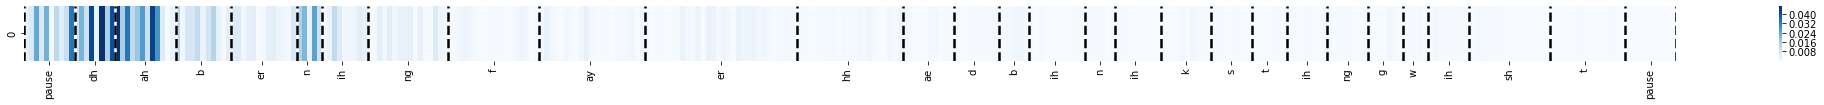

for T


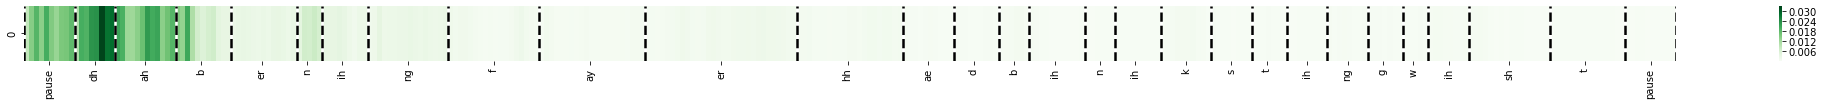

_THE_ _BA_N_I_NG_ FI_RE HA_D BE_EN E_X_TI_NGUISHED_ england
for T


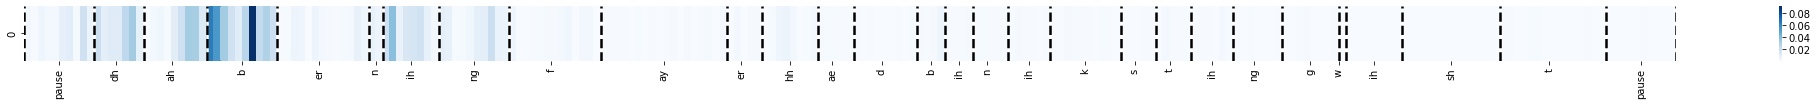

for T


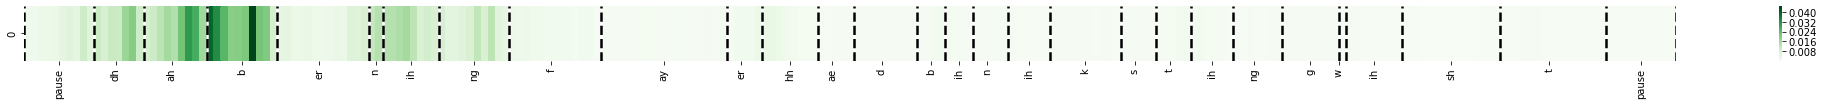

_THE_ _BU_R_N_ING_ FI_RE_ HAD_ BE_EN E_XTI_NGUI_SHED_ australia
for T


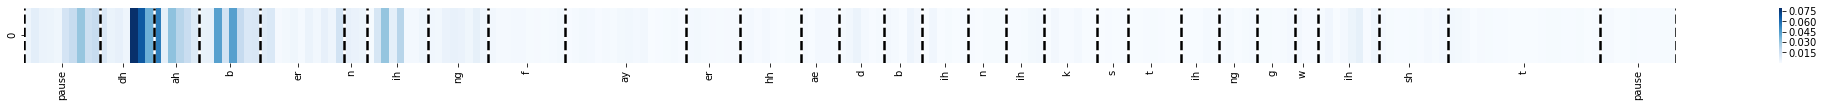

for T


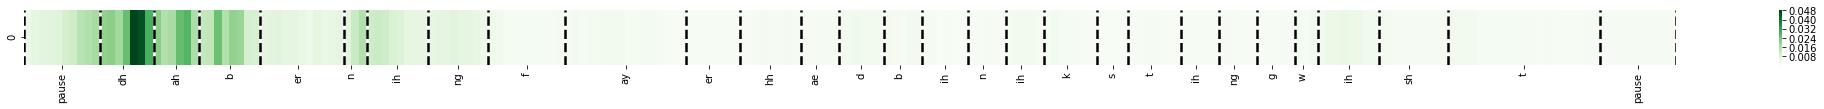

_THE_ _BU_R_N_ING_ FI_RE A_B_S_H_ _BE_N_ E_X_TI_NGUI_SHED_ indian
for T


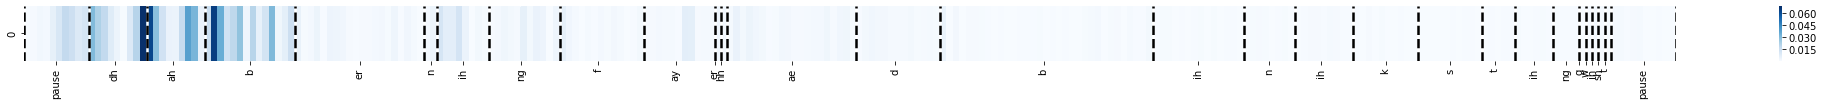

for T


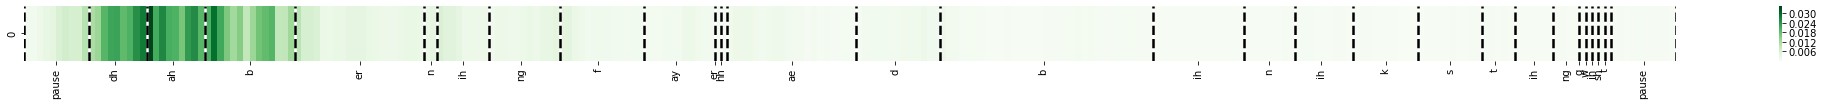

_THE_ FU_R_N_I_N_ FI_RE_ HO_D_ HE_EN_ E_X_TE_N_T_I_V_ scotland
for T


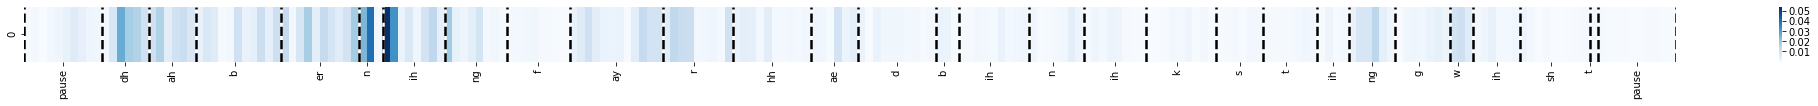

for T


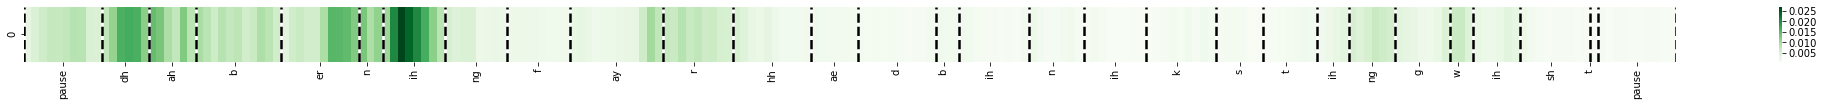

_THE_ BUR_N_I_N_ FLA_R_ HA_D_ BE_EN _E_S_TI_NGUI_SHED_ african
for T


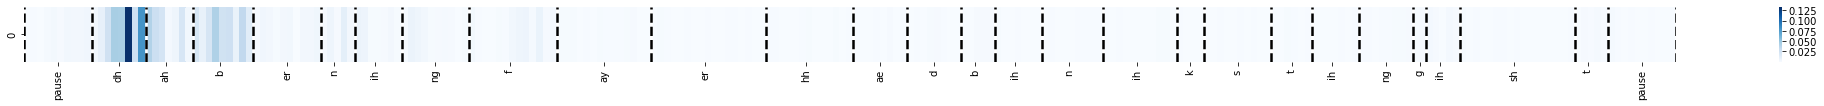

for T


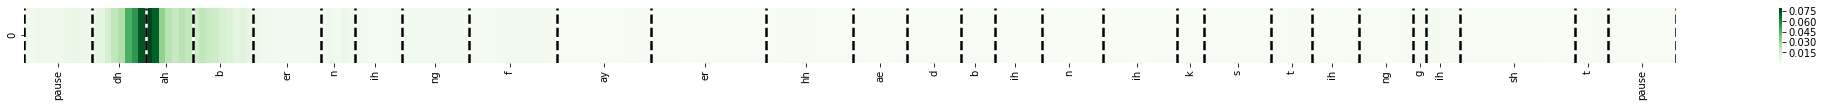

_THE_ HE_R_N_I_NG_ FI_RE_ HA_D_ BE_EN E_XTI_NGUI_SHED_ us
for T


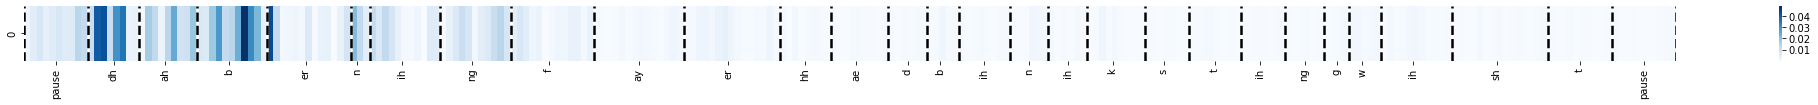

for T


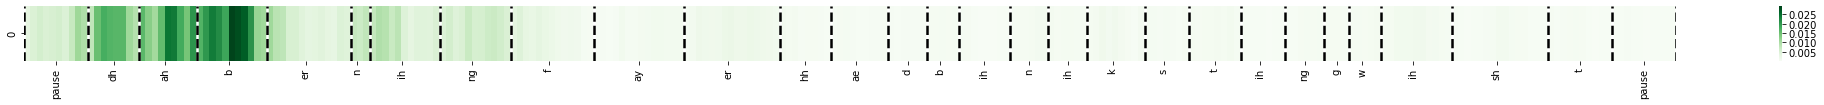

In [37]:
fig = plt.figure(figsize = (37,20))
for file in trans_dict[target_transcript]:
    try:
        Fs, wav = wavfile.read('my_data/MCV_validated_{}/wav/{}.wav'.format(file_meta[file]['accent'],file))
        display(Audio(wav, rate=Fs))
        with open('attribution/grad/{}.pickle'.format(file), 'rb') as j:
            file_attr = pickle.load(j)
        print(file_attr['output'], file_meta[file]['accent'])
        #print(list(file_attr['attr dict'].keys()))
        inp_grad_grapheme(file, grapheme_idx)
        grad_grapheme(file,grapheme_idx)
        
    except:
        continue

#### (B) Word Level

_THE_ BU_R_N_I_NG_ FI_RE_ HA_D_ BE_EN E_XTI_NGUI_SHED_ canada
FIRE


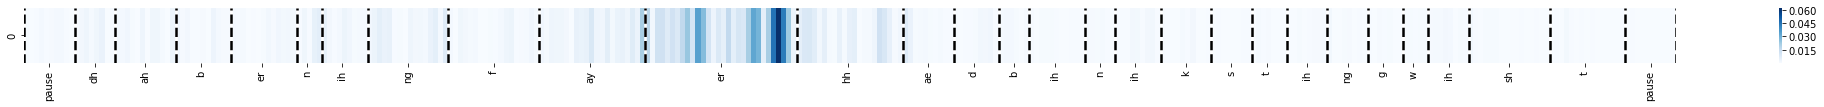

Focus word: FIRE


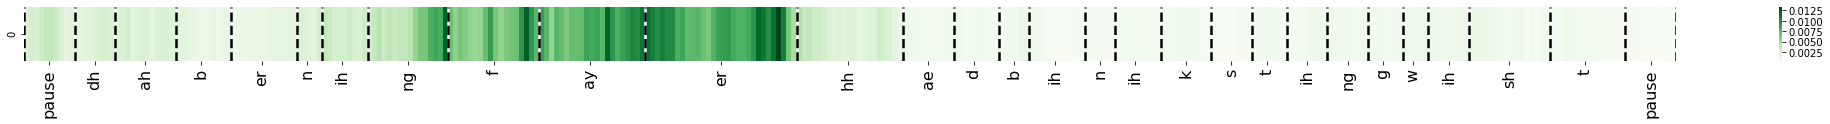

_THE_ _BA_N_I_NG_ FI_RE HA_D BE_EN E_X_TI_NGUISHED_ england
FIRE


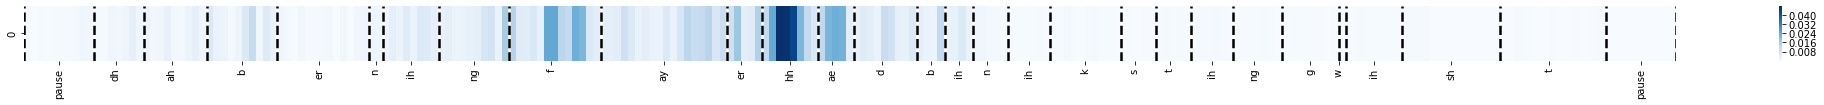

Focus word: FIRE


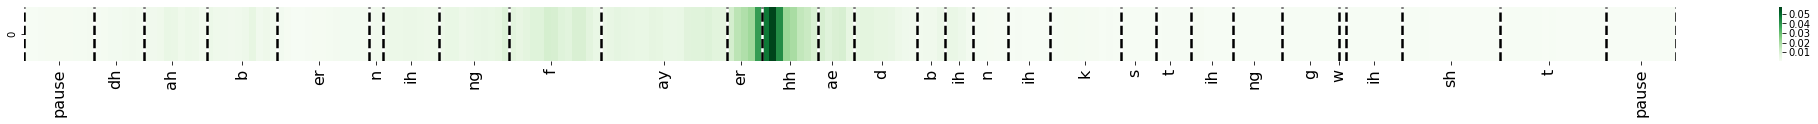

_THE_ _BU_R_N_ING_ FI_RE_ HAD_ BE_EN E_XTI_NGUI_SHED_ australia
FIRE


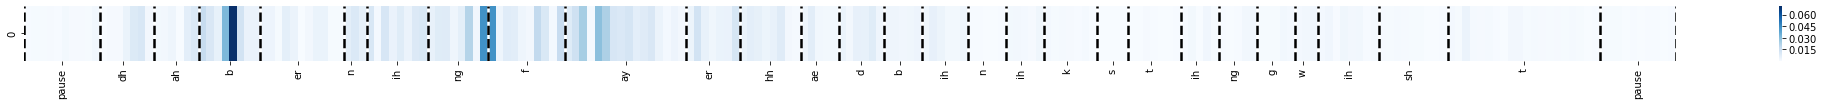

Focus word: FIRE


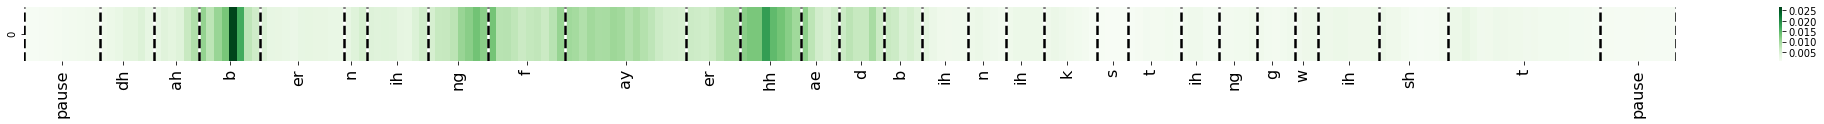

_THE_ _BU_R_N_ING_ FI_RE A_B_S_H_ _BE_N_ E_X_TI_NGUI_SHED_ indian
FIRE


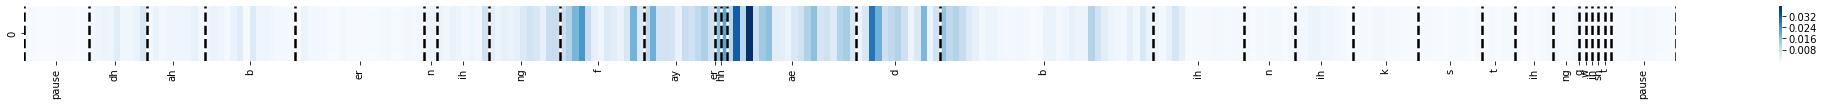

Focus word: FIRE


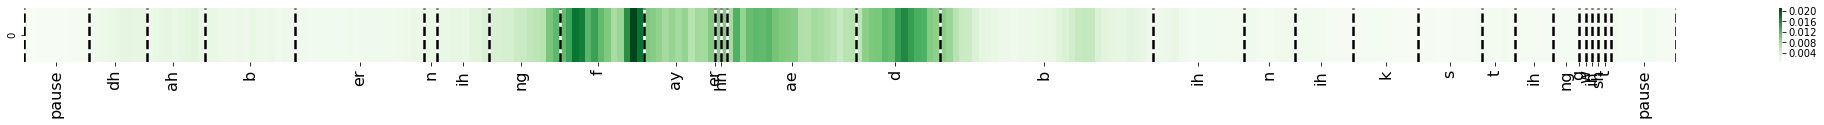

_THE_ FU_R_N_I_N_ FI_RE_ HO_D_ HE_EN_ E_X_TE_N_T_I_V_ scotland
FIRE


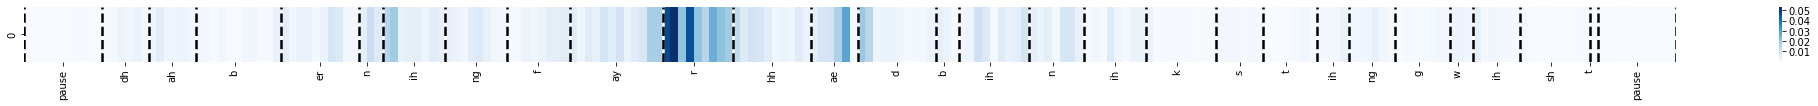

Focus word: FIRE


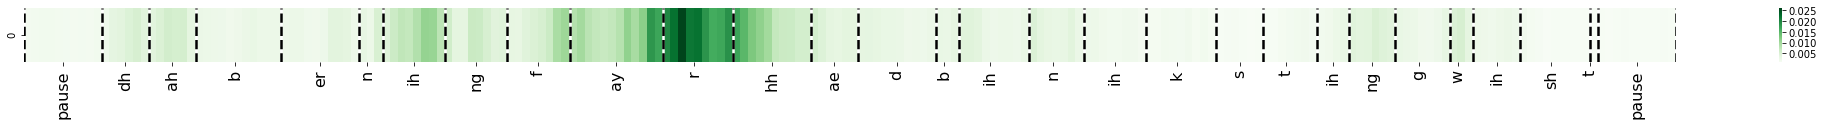

_THE_ BUR_N_I_N_ FLA_R_ HA_D_ BE_EN _E_S_TI_NGUI_SHED_ african
FLAR


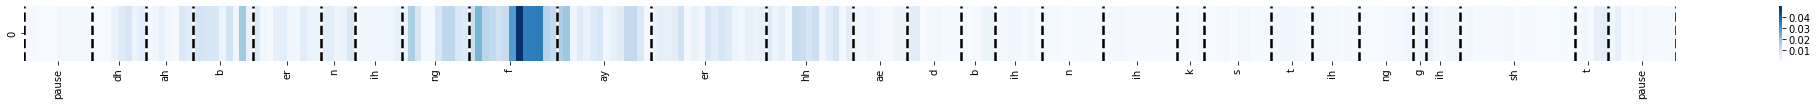

Focus word: FLAR


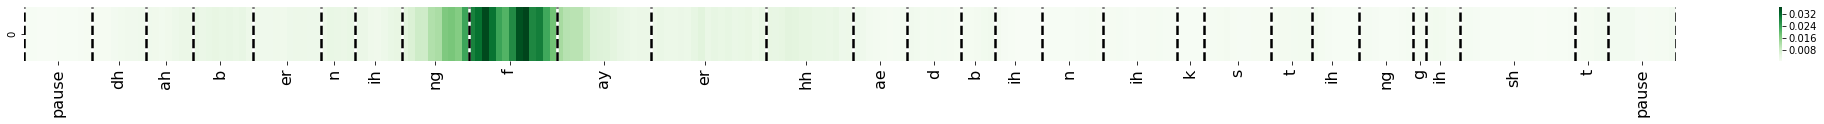

_THE_ HE_R_N_I_NG_ FI_RE_ HA_D_ BE_EN E_XTI_NGUI_SHED_ us
FIRE


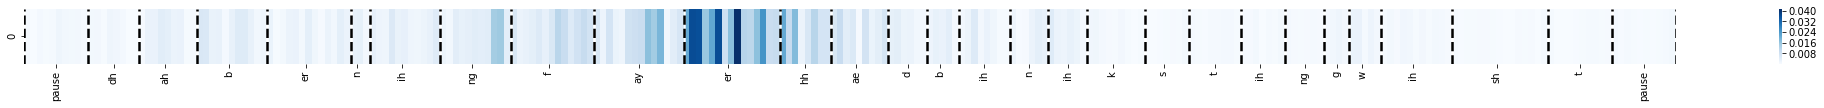

Focus word: FIRE


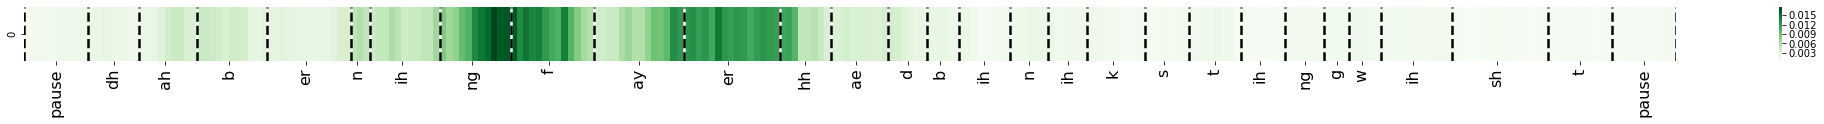

In [39]:
word_idx = 4
for file in trans_dict[target_transcript]:
    try:
        Fs, wav = wavfile.read('my_data/MCV_validated_{}/wav/{}.wav'.format(file_meta[file]['accent'],file))
        display(Audio(wav, rate=Fs))
        with open('attribution/grad/{}.pickle'.format(file), 'rb') as j:
            file_attr = pickle.load(j)
        print(file_attr['output'], file_meta[file]['accent'])
        #print(list(file_attr['attr dict'].keys()))
        inp_grad_word(file, word_idx)
        #print(file_meta[file]['accent'])
        grad_word(file,word_idx)
#     break
    except:
        continue

In [91]:
syllables = pickle.load(open('syll.pickle','rb'))
syllables['THE']

[{'pron': 'DH AH', 'syll': [(['DH'], ['AH'], [])]},
 {'pron': 'DH IY', 'syll': [(['DH'], ['IY'], [])]}]

In [93]:
syllables['PEOPLE']

[{'pron': 'P IY P AH L',
  'syll': [(['P'], ['IY'], []), (['P'], ['AH'], ['L'])]}]

In [20]:
def is_correct(s1, s2, idx):
        """
        Computes the Word Error Rate, defined as the edit distance between the
        two provided sentences after tokenizing to words.
        Arguments:
            s1 (string): space-separated sentence
            s2 (string): space-separated sentence
        """

        # build mapping of words to integers
        b = set(s1.split() + s2.split())
        word2char = dict(zip(b, range(len(b))))

        # map the words to a char array (Levenshtein packages only accepts
        # strings)
        w1 = [chr(word2char[w]) for w in s1.split()]
        w2 = [chr(word2char[w]) for w in s2.split()]
        ops = Lev.editops(''.join(w1), ''.join(w2))
        #print(ops)
        words_changed = [x[1] for x in ops]
        
        return not idx in words_changed
        


In [608]:
cond_transcripts = []
for t in transcripts:
    
    order = sorted(transcript_wer[t], key=lambda k: transcript_wer[t][k])
    #print(order)
    if(order[0]== 'canada' or order[0] == 'us'):
        cond_transcripts.append(t)
    
 # do this after LM rescoring ?   

In [592]:
print(len(cond_transcripts))

174


In [604]:
print(cond_transcripts[:20])

['The top had certainly ceased to rotate.', 'It had a diameter of about thirty yards.', 'They were known as seers, and they were held in fear by women and the elderly.', 'Would anyone care for some lavender custard?', 'She refilled her vessel and left.', 'Our merchants bought that man, and brought him to Egypt.', 'The boy picked up his pouch and put it with his other things.', 'Why did we have to have all these kids?', 'But they were not there.', 'But arms cannot be drawn unless they also go into battle.', 'Henderson stood up with a spade in his hand.', 'He was shaken into wakefulness by someone.', 'The level ground was blackened as far as one could see, and it was still giving off smoke.', 'Night fell, and an assortment of fighting men and merchants entered and exited the tent.', 'Everyone, when they are young, knows what their destiny is.', 'It was the first time she had done that.', 'I was scared, but wasted no time in going out and crossing the bridge to the sand pits.', 'Where did

In [268]:
all_words = []
valid_punctuation = string.punctuation.replace("'","")
for t in transcripts:
    t_ = t.strip().upper()
    t_ = t_.translate(str.maketrans({a:None for a in valid_punctuation }))
    all_words.extend(t_.split())
    #print(all_words)
    #break
    

##### Calculate Most Frequent Words

In [269]:
allWordDist = nltk.FreqDist(all_words)
record_frequency = allWordDist.most_common(75)
most_frequent = [ x[0] for x in record_frequency]

In [779]:
print(most_frequent)


['THE', 'TO', 'AND', 'A', 'OF', 'WAS', 'I', 'IT', 'HE', 'THAT', 'IN', 'YOU', 'HAD', 'HIS', 'AS', 'BUT', 'WITH', 'BOY', 'IS', 'THEY', 'WERE', 'FOR', 'AT', 'ABOUT', 'BE', 'ON', 'ME', 'THERE', 'FROM', 'MY', 'WE', 'HIM', 'HAVE', 'NOT', 'OUT', 'THIS', 'SOME', 'ALL', 'THOUGHT', 'AN', 'PEOPLE', 'BEEN', 'HER', 'INTO', 'TIME', 'YOUR', 'SO', 'ARE', 'HERE', 'CAN', 'GET', 'THEN', 'WAY', 'SHE', 'ONE', 'WHEN', 'ONLY', "DON'T", "I'M", 'OTHER', 'UP', 'WHAT', 'SEE', 'COULD', 'LITTLE', 'NO', 'GOING', 'DO', 'WILL', 'IF', 'ITS', 'MORE', 'BY', 'MAN', 'STILL']


In [21]:
most_frequent = ['THE', 'TO', 'AND', 'A', 'OF', 'WAS', 'I', 'IT', 'HE', 'THAT', 'IN', 'YOU', 'HAD', 'HIS', 'AS', 'BUT', 'WITH', 'BOY', 'IS', 'THEY', 'WERE', 'FOR', 'AT', 'ABOUT', 'BE', 'ON', 'ME', 'THERE', 'FROM', 'MY', 'WE', 'HIM', 'HAVE', 'NOT', 'OUT', 'THIS', 'SOME', 'ALL', 'THOUGHT', 'AN', 'PEOPLE', 'BEEN', 'HER', 'INTO', 'TIME', 'YOUR', 'SO', 'ARE', 'HERE', 'CAN', 'GET', 'THEN', 'WAY', 'SHE', 'ONE', 'WHEN', 'ONLY', "DON'T", "I'M", 'OTHER', 'UP', 'WHAT', 'SEE', 'COULD', 'LITTLE', 'NO', 'GOING', 'DO', 'WILL', 'IF', 'ITS', 'MORE', 'BY', 'MAN', 'STILL']

In [33]:
mf_us = {x:[] for x in most_frequent}
mf_canada = {x:[] for x in most_frequent}
mf_indian = {x:[] for x in most_frequent}
mf_african = {x:[] for x in most_frequent}
mf_england = {x:[] for x in most_frequent}
mf_scotland = {x:[] for x in most_frequent}
mf_australian = {x:[] for x in most_frequent}
mf_accents = {'us':mf_us,'canada':mf_canada,'indian':mf_indian,'african':mf_african,'england':mf_england,'scotland':mf_scotland,'australia':mf_australian}

In [1061]:
#transcript_freq = {}
for t in transcripts:
    
    t_ = t.strip().upper()
    t_ = t_.translate(str.maketrans({a:None for a in valid_punctuation }))
    
    t_list = t_.split()
    true_nz_counts = {x:t_list.count(x) for x in most_frequent if t_list.count(x) > 0}
    true_nz_indices = {x:[index for index, value in enumerate(t_list) if value == x] for x in true_nz_counts.keys()}
    #print(true_nz_counts)
    for file in trans_dict[t]:
        try:
            acc = {x:0 for x in true_nz_counts.keys()}
            with open('attribution/grad/{}.pickle'.format(file), 'rb') as j:
                file_attr = pickle.load(j)
            op = file_attr['output'].replace('_', '')
            accent = file_meta[file]['accent']
            
            
            for w in true_nz_counts.keys():
                
                for j in true_nz_indices[w]:
                #mf_accents[accent][w][0].append(true_nz_counts[w])
                    
                    mf_accents[accent][w].append(is_correct(t_,op,j))
                #print(cond)
           
                #mf_accents[accent][w][1].append(min(op.split().count(w),true_nz_counts[w]))
        except:
            continue
    
        #print(mf_accents[accent])
    
        

In [1181]:
#print(mf_us)
mf_us = {x:[] for x in most_frequent}
mf_canada = {x:[] for x in most_frequent}
mf_indian = {x:[] for x in most_frequent}
mf_african = {x:[] for x in most_frequent}
mf_england = {x:[] for x in most_frequent}
mf_scotland = {x:[] for x in most_frequent}
mf_australian = {x:[] for x in most_frequent}
avg_stats =  {'us':mf_us,'canada':mf_canada,'indian':mf_indian,'african':mf_african,'england':mf_england,'scotland':mf_scotland,'australia':mf_australian}
#print(avg_stats)

In [ ]:
for a in mf_accents.keys():
    print(a)
    #a = 'indian'
    for w in mf_accents[a].keys():
        
        avg_stats[a][w].append(sum(mf_accents[a][w])/len(mf_accents[a][w]))
        
        #print(w,np.asarray(mf_accents[a][w]).mean(),np.asarray(mf_accents[a][w]).std())
    
  

##### Accuracy of correctly predicting most frequent words across accents

In [1183]:
for a in avg_stats.keys():
    temp = []
    for k in avg_stats[a].keys():
        temp.append(avg_stats[a][k][0])
    print(a, np.asarray(temp).mean(), np.asarray(temp).std())

us 0.7803950509449439 0.121667382968697
canada 0.8572825991328428 0.10528083986888306
indian 0.513035145387385 0.18122269227720902
african 0.7522708227207352 0.1365991362807828
england 0.6919775766172566 0.16313311778908576
scotland 0.6535836230311115 0.1547649386757295
australia 0.7459351700052215 0.14893722495703424


In [46]:
us = [0.7803950509449439, 0.121667382968697]
canada =[0.8572825991328428, 0.10528083986888306]
indian =[0.513035145387385, 0.18122269227720902]
african =[0.7522708227207352, 0.1365991362807828]
england =[0.6919775766172566, 0.16313311778908576]
scotland =[0.6535836230311115, 0.1547649386757295]
australia =[0.7459351700052215, 0.14893722495703424]
acc = {'us':us,'indian':indian,'canada':canada,'african':african,'england':england,'scotland':scotland,'australia':australia}

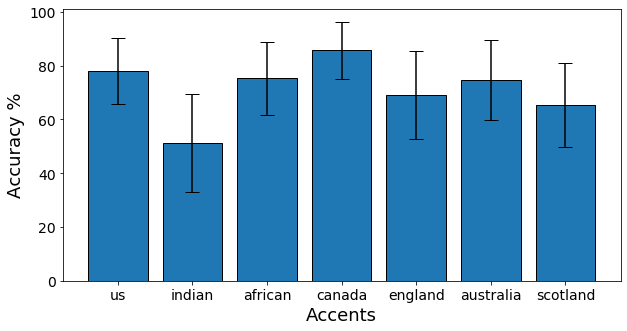

In [49]:
objects = ['us', 'indian', 'african', 'canada', 'england', 'australia', 'scotland']
y_pos = np.arange(len(objects))
#fig = plt.figure(figsize = (15,10))
# def create_plots(layer, name):
fig = plt.figure(figsize = (10,5))
y_pos = np.arange(len(objects))
y = [100*acc[x][0] for x in objects ]
err = [100*acc[x][1]  for  x in objects]
#plt.plot(y_pos, y,'-o', alpha=0.7,)
#plt.figure()
plt.bar(y_pos, y, yerr= err,align='center', capsize=7, edgecolor='k')
plt.xticks(y_pos, objects, fontsize=14)
plt.yticks(fontsize=14)
# plt.errorbar(y_pos, y, yerr=err,fmt='-o',capsize=5 )
# plt.xticks(y_pos, objects)
#plt.ylim(ymin = 0)obj
#plt.axhline(14.28, linewidth=1, color='k')
plt.ylabel('Accuracy %',color='k',fontsize=18)
plt.xlabel('Accents',color='k',fontsize=18)
#plt.title('MF words classificant trends')
#plt.legend(frameon=False)
plt.savefig('MF-words.pdf',bbox_inches='tight')
plt.show()


##### Helper Function for alligning words with frames

In [22]:
def get_word_allignment(file, input_size):
    alligned = []
    spec_stride = 0.01
    window_size = 0.02
    times = file_meta[file]['end_times']
    json_path = 'my_data/align_common/{}.json'.format(file)
    with open(json_path,'r') as j:
        gentle = json.load(j)
    word_ends = []
    word_ends.append(('start',times[0]))
    for g in range(len(gentle['words'])):
        word_ends.append((gentle['words'][g]['word'], gentle['words'][g]['end']))
    word_ends.append(('end',times[-1]))
    
    #last_idx = 0
    for i in range(input_size):
        frame_idx = i
        window_start = frame_idx*spec_stride
        window_mid = window_start + (window_size/2)
        alligned_word = 'na'
        for j in range(len(word_ends)):
            if (window_mid < word_ends[j][1]):
                alligned_word = word_ends[j][0]
                break
        #assert alligned_phone != 'na', "Failed to fetch allignment"
        if(alligned_word != 'na'):
            alligned.append(alligned_word)
            #last_idx = i
    pause_start = 0
    pause_end = len(alligned)
    for i in range(len(alligned)):
        if(alligned[i] != 'start'):
            break
        pause_start = i
    
    for i in range(len(alligned)-1,-1,-1):
        if(alligned[i] != 'end'):
            break
        pause_end = i
        
    #print(last_idx)
    
    return alligned, pause_start+1, pause_end,
    

In [902]:
wrd = get_word_allignment('common_voice_en_540956', 100000)

### Visualizing attribution of a particular word

In [23]:
def grad_clubbed_word(file, word_idx, disable_prints = False):
    
    #try:
        #file = 'common_voice_en_110121'
        #print(file)
#         Fs, wav = wavfile.read('my_data/MCV_validated_{}/wav/{}.wav'.format(file_meta[file]['accent'],file))
#         display(Audio(wav, rate=Fs))
    with open('attribution/grad/{}.pickle'.format(file), 'rb') as j:
        file_attr = pickle.load(j)
#         print(file_attr['output'], file_meta[file]['accent'])

#         print(file_attr['output'].split(' '))
    normalized_attr = get_norm_attr(file_attr['grad_dict'])
    keys = list(normalized_attr.keys())
#         print(keys)
    spaces = get_space(file_attr['output'])
    indices = [keys.index(x) for x in spaces]
    words = get_words(keys,indices, spaces)
    input_size = len(file_attr['grad_dict'][list(file_attr['grad_dict'].keys())[0]]) # calculate properly once
    buffer = 10
    plot_vertical = False
    #word_idx = 8
#         print(words)
#         print(keys)

    word_activation = np.sum(np.asarray([np.abs(normalized_attr[idx]) for idx in words[word_idx]] ), axis = 0)
    

    if(plot_vertical):
        fig = plt.figure(figsize = (1,35))
        print(get_frame_allignment(file, input_size))
        allignments, p_start, p_end = get_word_allignment(file, input_size)
        allignments = np.asarray(allignments)            
        actual_size = len(allignments)
        sns.heatmap(np.expand_dims(normalized_attr[1][:actual_size], axis = 1),annot = np.expand_dims(allignments, axis = 1), fmt="", cmap='RdBu')

        plt.show()
    else:
        str_list = []
        for x in words[word_idx]:
            str_list.append(file_attr['output'][x])


        
        allignments, p_start, p_end = get_frame_allignment(file, input_size)
        wrd_allignments,w_start,w_end = get_word_allignment(file, input_size)
        wrd_allignments = np.asarray(wrd_allignments)
        allignments = np.asarray(allignments)            
        actual_size = len(allignments)
        #actual_size = len(allignments)
        
        #plt.yticks(rotation=) [p_start - buffer:p_end + buffer]
        modified_allignments = allignments[p_start - buffer:p_end + buffer]
        assert len(wrd_allignments) == len(allignments), "dimensions don't match"
        
        modified_wrd_allignments = wrd_allignments[w_start - buffer:w_end + buffer]
        #assert len(modified_wrd_allignments) == len(modified_allignments), "dimensions don't match"
        #wrds = [list(x[0]) for x in groupby(modified_wrd_allignments)]
        wrd_labels = [list(x[1]) for x in groupby(modified_wrd_allignments)]
        #print(wrd_labels)
        wrd_indices = [0]
        for j in wrd_labels:
            wrd_indices.append(wrd_indices[-1] + len(j))
        #print(wrd_indices)
        my_arr = word_activation[w_start - buffer:w_end + buffer]/np.sum(word_activation[w_start - buffer:w_end + buffer])
        wrd_combined_wonorm = []
        wrd_combined = []
        for m in range(len(wrd_labels)):
            wrd_combined_wonorm.append(np.sum(my_arr[wrd_indices[m]:wrd_indices[m+1]]))
            wrd_combined.append(np.sum(my_arr[wrd_indices[m]:wrd_indices[m+1]])/len(wrd_labels[m]))
        wrd_combined = np.asarray(wrd_combined)
        
        wrd_combined = wrd_combined/np.sum(wrd_combined)
        
        #print(np.asarray(wrd_combined).sum())
        if(not disable_prints):
            print(''.join(str_list))
            fig = plt.figure(figsize = (37,1))
            sns.heatmap(np.expand_dims(word_activation[p_start - buffer:p_end + buffer]/np.sum(word_activation[p_start - buffer:p_end + buffer]), axis = 0), fmt="", cmap='Greens')
            phone_labels = [x[0] for x in groupby(modified_allignments)]
            len_list = [len(list(x[1])) for x in groupby(modified_allignments)]
            idx_list = [0]
            ticks_list = []
            for l in len_list:
                ticks_list.append(idx_list[-1] + l//2)
                idx_list.append(idx_list[-1] + l)


            plt.xticks(ticks_list,phone_labels, rotation = 90)

            for j in idx_list:
                plt.axvline(x=j, color='w', linestyle='-', linewidth=2.5)
                plt.axvline(x=j, color='k', linestyle='--', linewidth=2.5)


            plt.show()
            print(wrd_combined_wonorm)
            print(wrd_combined)  
            fig2 = plt.figure(figsize = (37,1))
            #my_arr = word_activation[w_start - buffer:w_end + buffer]/np.sum(word_activation[w_start - buffer:w_end + buffer])
            plt.plot(word_activation[p_start - buffer:p_end + buffer]/np.sum(word_activation[p_start - buffer:p_end + buffer]))
            xk = np.arange(len(my_arr))
            #pk = (0.1, 0.2, 0.3, 0.1, 0.1, 0.0, 0.2)        
            custm = st.rv_discrete(name='custm', values=(xk, my_arr))
            print(custm.mean(), custm.std())
              
            #print(my_arr.mean(), my_arr.std())
            #plt.xticks(ticks_list,phone_labels, rotation = 90)
            plt.xlim(xmin = 0, xmax = len(word_activation[p_start - buffer:p_end + buffer]/np.sum(word_activation[p_start - buffer:p_end + buffer])))


            plt.show()

            fig3 = plt.figure(figsize = (37,1))
            my_arr = wrd_combined
            plt.plot(my_arr)
            xk = np.arange(len(my_arr))
            #pk = (0.1, 0.2, 0.3, 0.1, 0.1, 0.0, 0.2)        
            custm = st.rv_discrete(name='custm', values=(xk, my_arr))
            print(custm.mean(), custm.std())
            #print(my_arr.mean(), my_arr.std())
            #plt.xticks(ticks_list,phone_labels, rotation = 90)
            plt.xlim(xmin = 0, xmax = len(my_arr))


            plt.show()
        #else:
        return wrd_combined, wrd_combined_wonorm



##### Visualizing normalized attributions at granularity of frames and words

_I_ WA_S_ _CA_RED_ _BU_T_ _WE_ST_ERE_D_ NO_ TI_ME _I_N_ _GO_INI_NG_ O_U_T_ _A_ND_ C_LO_S_S_ING THE_ B_RI_DGE_ TO_ THE_ SA_ND_ FWI_CT_ indian
[1, 3, 4, 5, 7, 9, 11, 12, 14, 15, 16, 18, 20, 21, 23, 25, 27, 28, 30, 31, 33, 34, 35, 37, 39, 40, 41, 43, 44, 45, 47, 48, 49, 51, 53, 55, 57, 58, 60, 61, 62, 64, 65, 67, 68, 70, 72, 74, 76, 78, 79, 81, 82, 84, 85, 87, 89, 91, 92, 93, 94, 95, 96, 97, 99, 100, 102, 103, 105, 106, 107, 109, 110, 111, 113, 114, 115, 116, 118, 119, 120, 122, 123, 125, 126, 127, 128, 130, 131]
common_voice_en_169428
CARED


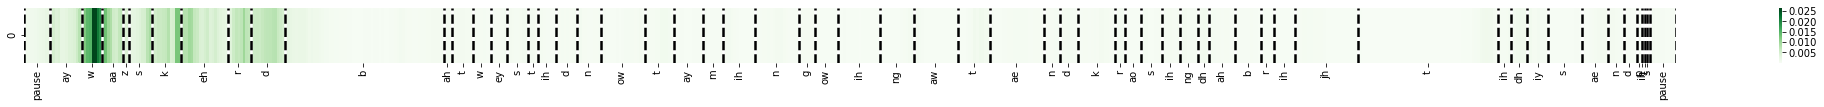

[0.019153342, 0.05517202, 0.22629882, 0.38506073, 0.0758245, 0.025988404, 0.014110849, 0.017039925, 0.015882544, 0.016283272, 0.015629934, 0.020159401, 0.02742129, 0.009940491, 0.017648492, 0.019887641, 0.0142622925, 0.01681535, 0.0022992557, 0.0051214495]
[0.0538 0.1292 0.374  0.1803 0.0292 0.0183 0.0152 0.016  0.0154 0.0104
 0.0157 0.0162 0.0167 0.0199 0.0105 0.0095 0.0286 0.0139 0.0129 0.0144]
137.7708149651371 161.731208978364


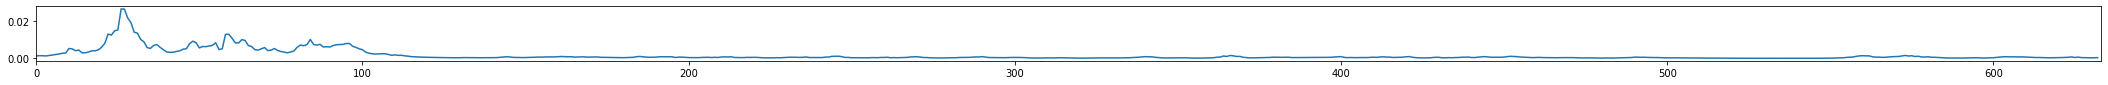

4.330427122693498 4.775199385442811


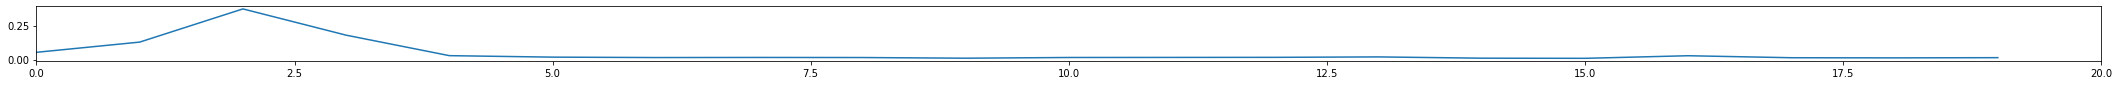

2 4.775199385442811


_I_ WA_S_ HE_RE_ BU_TH_ _WA_I_ST_E_G_ _NO_R_ TI_ME_ _I_N_ _GO_ING O_U_T_ AND_ _C_RO_S_S_ING_ THE_ B_RE_E_D_S_ TO_ U_S _O_U_BE_A_KT_S_ england
[1, 3, 4, 5, 7, 9, 10, 11, 13, 14, 16, 17, 18, 20, 21, 23, 25, 26, 28, 30, 31, 33, 35, 37, 39, 40, 42, 44, 45, 46, 48, 49, 51, 53, 55, 57, 59, 60, 62, 63, 64, 65, 66, 68, 70, 72, 73, 74, 75, 77, 79, 81, 82, 84, 86, 88, 89, 90, 92, 93, 94, 95, 97, 98, 100, 101, 103, 105, 107, 109, 110, 111, 113, 114, 116, 117, 119, 121, 123, 124, 126, 128, 129, 131]
common_voice_en_693510
HERE


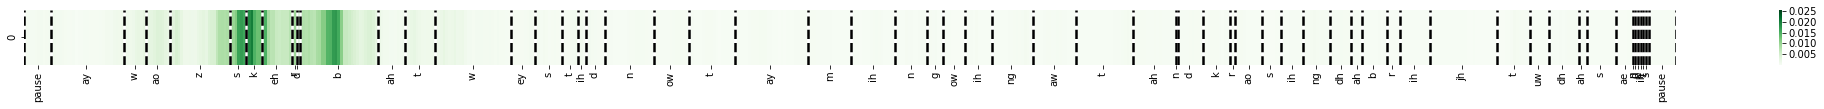

[0.008185587, 0.023201773, 0.14511377, 0.29980198, 0.28921545, 0.06510271, 0.0165232, 0.02466133, 0.012869552, 0.016702525, 0.016180884, 0.013709152, 0.02178319, 0.006432434, 0.014839628, 0.008041649, 0.0067711356, 0.0057304977, 0.0012064745, 0.003927066]
[0.0273 0.0286 0.124  0.3996 0.189  0.0339 0.0178 0.0142 0.0148 0.0143
 0.0146 0.0176 0.0154 0.0179 0.0099 0.0141 0.0161 0.01   0.008  0.0131]
148.70132761287095 128.31238839180307


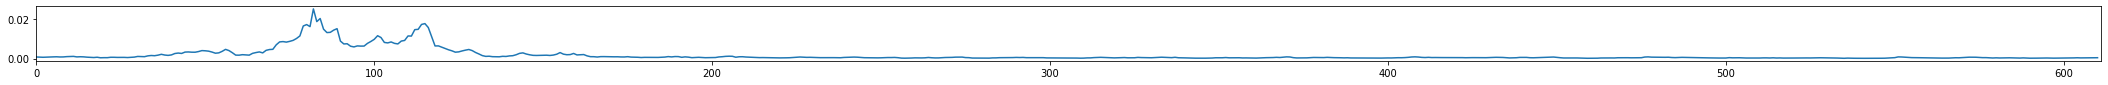

4.781447332029676 4.105982497602087


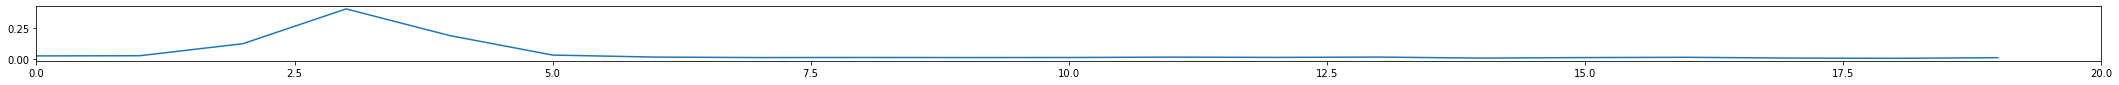

3 4.105982497602085


_I_ WA_S_ S_CA_RED_ BE_T WA_STED_ NO_ TI_ME I_N_ GO_ING O_U_T_ AND_ _CRO_SI_SING THE BRE_DGE_ TO_ THE_ SA_ND_ME_T_Z_ scotland
[1, 3, 4, 5, 7, 9, 10, 12, 13, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35, 37, 38, 39, 41, 42, 43, 44, 46, 48, 49, 50, 52, 53, 54, 55, 56, 58, 60, 62, 63, 64, 65, 67, 69, 70, 71, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 91, 93, 94, 95, 97, 98, 99, 100, 102, 103, 104, 106, 107, 109, 110, 112, 114]
common_voice_en_563330
SCARED


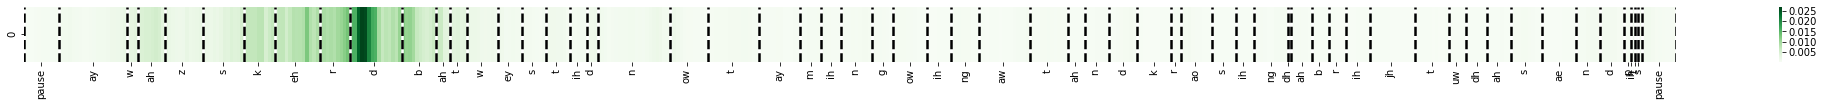

[0.006318982, 0.028144116, 0.075404905, 0.523731, 0.119218335, 0.05307912, 0.038166948, 0.023021959, 0.012186555, 0.0166606, 0.01380959, 0.010807793, 0.021657288, 0.003943345, 0.008822775, 0.0048715654, 0.005576444, 0.021135548, 0.0049197325, 0.008523365]
[0.0204 0.0453 0.1105 0.291  0.2022 0.045  0.0384 0.0232 0.0245 0.0173
 0.0171 0.0174 0.0155 0.0182 0.0098 0.0105 0.0138 0.0206 0.0317 0.0275]
130.16304536596 100.47523800614283


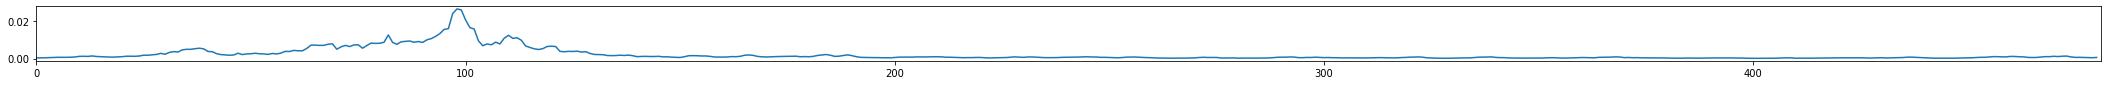

5.662223775894553 4.898042832016808


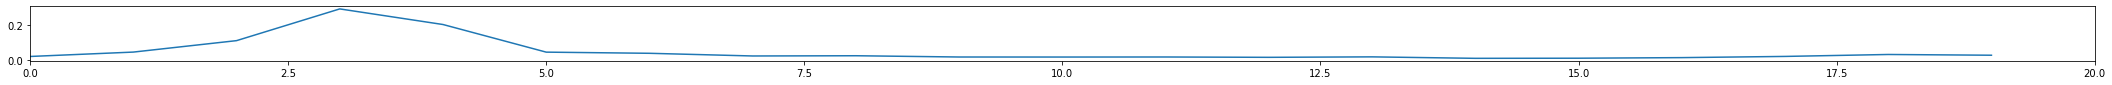

3 4.898042832016806


_I_ WA_S S_CA_RED_ BU_T WA_ST_E_D_ NO_ TI_ME_ _AND_ GO_ING O_UT_ _A_ND_ CRO_S_S_ING THE BRI_DGE_ TO_ THE_ SA_ND_ PI_T_S_ canada
[1, 3, 4, 5, 7, 8, 9, 11, 12, 14, 15, 16, 18, 19, 20, 22, 23, 24, 25, 27, 28, 30, 32, 34, 35, 36, 38, 39, 40, 42, 43, 45, 47, 48, 49, 51, 52, 53, 55, 56, 57, 58, 59, 61, 62, 64, 66, 68, 69, 71, 72, 73, 74, 76, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93, 94, 96, 97, 98, 100, 101, 102, 103, 105, 106, 107, 109, 110, 112, 113, 114, 116, 118]
common_voice_en_694791
SCARED


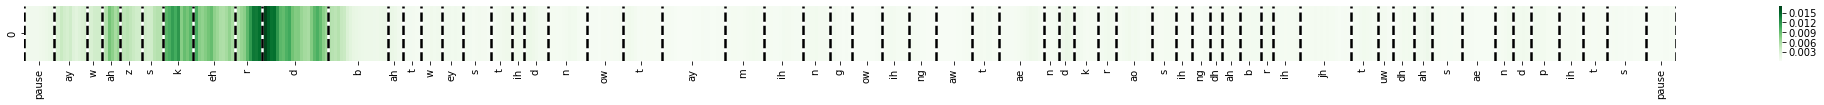

[0.012372775, 0.03598959, 0.084690474, 0.54523283, 0.07141752, 0.038130272, 0.013260779, 0.023309998, 0.013677176, 0.014404817, 0.008787983, 0.020202907, 0.02851077, 0.0057833274, 0.02263636, 0.008822639, 0.011121623, 0.018940013, 0.019418187, 0.003289984]
[0.0421 0.1113 0.1695 0.2992 0.0736 0.0309 0.0188 0.0169 0.0212 0.014
 0.0142 0.0275 0.0216 0.0197 0.0208 0.0214 0.0291 0.0195 0.0174 0.0112]
132.75105806342617 132.56846375325577


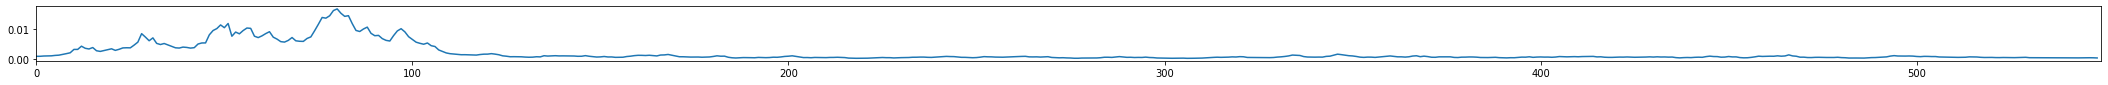

5.219209357855825 5.004216114887502


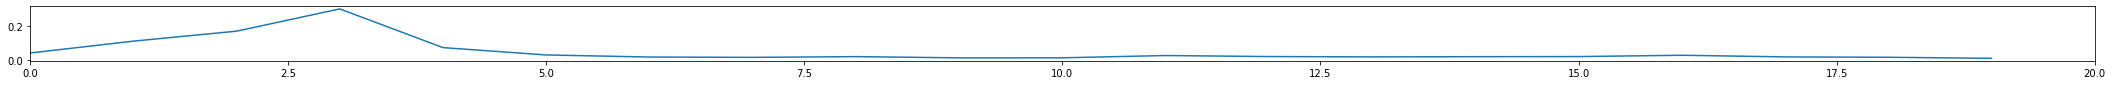

3 5.004216114887502


_I_ WA_S_ S_CA_RED_ BU_T WE_S T_E_D_ NO_ TI_ME I_N_ GO_ING_ O_U_T_ _AND_ CRO_S_S_ING_ THE_ B_RI_DGE_ TO_ THE_ SA_ND_ PI_T_'S_ african
[1, 3, 4, 5, 7, 9, 10, 12, 13, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 32, 34, 36, 37, 38, 40, 41, 42, 44, 45, 46, 47, 49, 51, 52, 53, 55, 56, 57, 59, 60, 62, 64, 66, 68, 69, 70, 72, 73, 74, 75, 77, 79, 81, 82, 83, 85, 86, 87, 88, 90, 91, 93, 94, 96, 97, 98, 100, 101, 102, 104, 105, 106, 107, 109, 110, 111, 113, 114, 116, 117, 118, 120, 122, 123]
common_voice_en_39132
SCARED


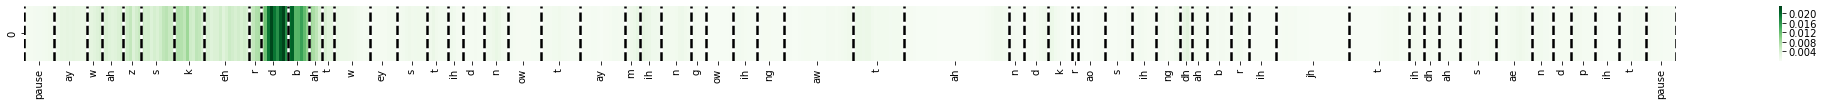

[0.009922913, 0.027512025, 0.06785717, 0.3612317, 0.16458106, 0.06136721, 0.019171929, 0.033309914, 0.023990862, 0.017617658, 0.0393559, 0.028995156, 0.032678504, 0.01260396, 0.022843424, 0.012827311, 0.007993605, 0.03349088, 0.016509973, 0.006138961]
[0.026  0.0655 0.1045 0.1931 0.2694 0.0321 0.0264 0.0257 0.0393 0.0149
 0.0264 0.0155 0.019  0.0413 0.0125 0.014  0.0174 0.0237 0.0173 0.0161]
153.1088051215338 140.46251216174585


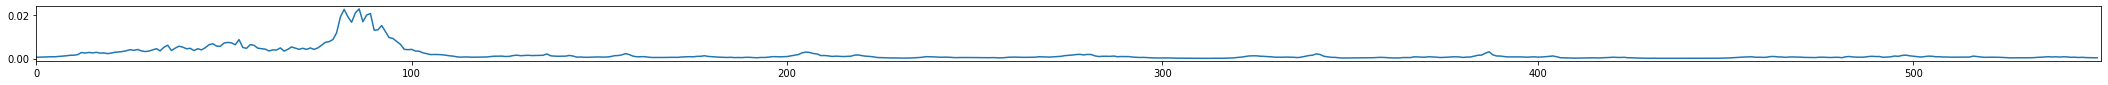

5.760734569625497 4.756040177523492


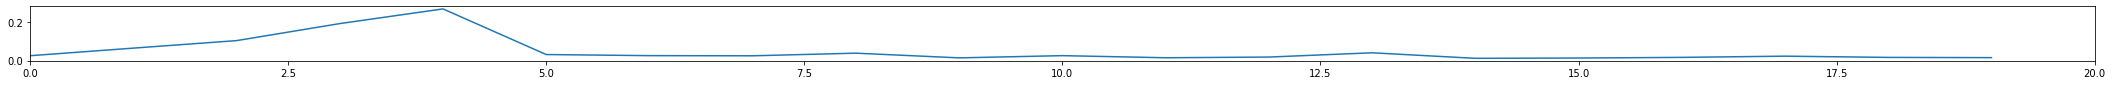

4 4.756040177523491


_I_ WA_S_ S_CA_RED_ BUT _WA_ST_ED NO_ TI_ME I_N_ _GO_ING O_UT_ AND C_ROS_S_ING_ THE_ B_RI_DGE_ TO_ THE_ SA_ND_ _BI_T_S_ australia
[1, 3, 4, 5, 7, 9, 10, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 25, 26, 28, 29, 31, 32, 33, 34, 35, 37, 38, 39, 41, 42, 43, 44, 46, 48, 50, 51, 53, 54, 55, 56, 57, 59, 60, 62, 63, 64, 65, 66, 67, 69, 70, 71, 73, 75, 76, 77, 79, 80, 81, 82, 84, 85, 87, 88, 90, 91, 92, 94, 95, 96, 98, 99, 100, 101, 103, 104, 105, 107, 108, 110, 112, 113, 115, 117]
common_voice_en_139735
SCARED


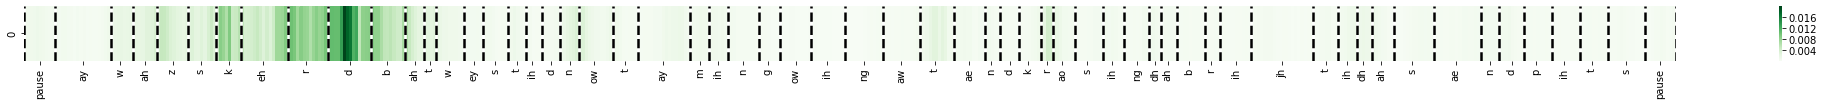

[0.012068409, 0.014925965, 0.06983492, 0.44708407, 0.10754053, 0.039837815, 0.034682106, 0.032546695, 0.013867525, 0.014639379, 0.028507935, 0.017780498, 0.045915853, 0.007994076, 0.02623789, 0.01242731, 0.014935219, 0.031695932, 0.021291979, 0.006185928]
[0.0382 0.0262 0.0921 0.2358 0.1621 0.0315 0.0646 0.0332 0.0274 0.0116
 0.0392 0.0256 0.0354 0.0281 0.0185 0.0303 0.0394 0.0239 0.0173 0.0196]
164.25470565534488 129.89758861744045


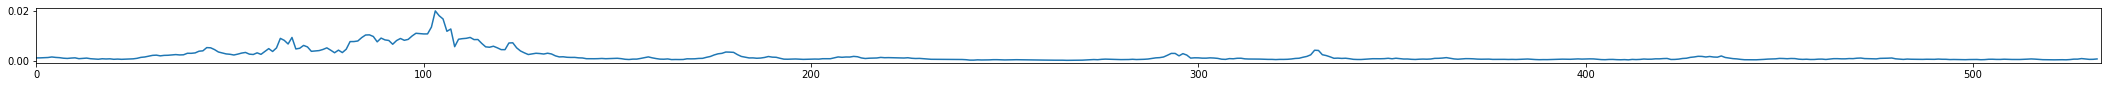

6.5636009557376305 5.13958968422318


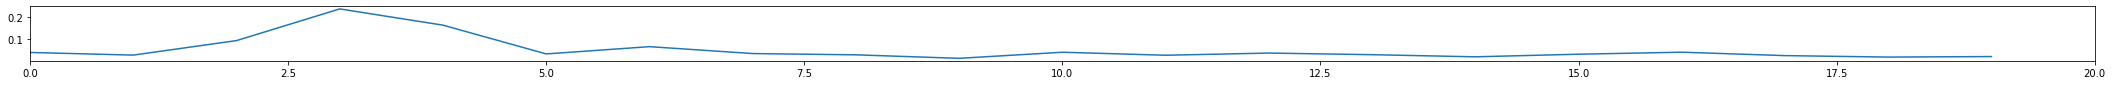

3 5.1395896842231785


_I_ WA_S_ S_CA_RED_ BUT I_ WA_ST_E_D_ NO_ TI_ME IN_ GO_ING O_U_T A_N_D_ CRO_S_S_ING_ THE_ B_RI_DGE_ TO_ THE_ SA_ND_ _PI_T_S_ us
[1, 3, 4, 5, 7, 9, 10, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28, 30, 31, 33, 35, 37, 38, 39, 41, 42, 43, 45, 46, 47, 48, 49, 51, 52, 53, 55, 56, 57, 58, 59, 61, 63, 64, 65, 67, 69, 71, 72, 73, 74, 76, 78, 80, 81, 82, 84, 85, 86, 87, 89, 90, 92, 93, 95, 96, 97, 99, 100, 101, 103, 104, 105, 106, 108, 109, 110, 112, 113, 115, 117, 118, 120, 122]
common_voice_en_510629
SCARED


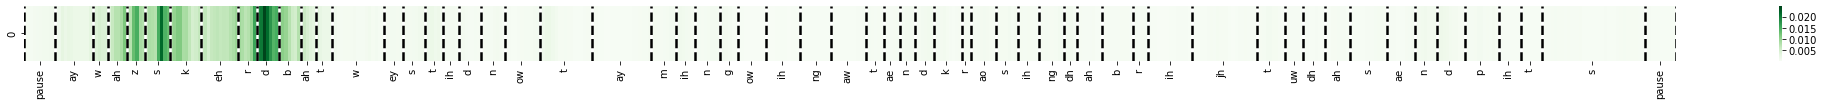

[0.010419409, 0.027589086, 0.12267031, 0.4634161, 0.098150894, 0.04718034, 0.0126636, 0.029974168, 0.012571912, 0.012681242, 0.007560403, 0.014114374, 0.030114274, 0.008028493, 0.023448998, 0.009679677, 0.0064892373, 0.029479196, 0.029642625, 0.0041257255]
[0.0283 0.0624 0.2082 0.286  0.1568 0.0267 0.0181 0.0185 0.0244 0.0096
 0.0121 0.0225 0.0199 0.0182 0.0127 0.0164 0.0126 0.0216 0.0139 0.0112]
124.03336993446283 128.43986528255888


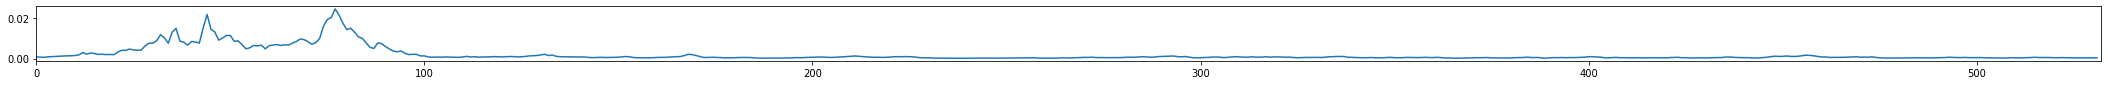

4.916821000734505 4.521426323248073


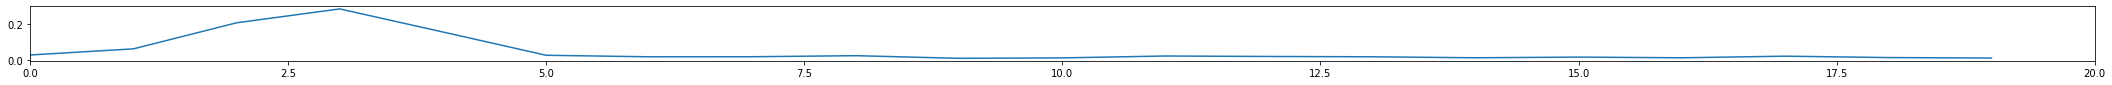

3 4.521426323248073


In [1263]:
#target_transcript = 'I was scared, but wasted no time in going out and crossing the bridge to the sand pits.'

for file in trans_dict[target_transcript]:
    Fs, wav = wavfile.read('my_data/MCV_validated_{}/wav/{}.wav'.format(file_meta[file]['accent'],file))
    display(Audio(wav, rate=Fs))
    with open('attribution/grad/{}.pickle'.format(file), 'rb') as j:
        file_attr = pickle.load(j)
    print(file_attr['output'], file_meta[file]['accent'])
    print(list(file_attr['attr dict'].keys()))
    #inp_grad_grapheme(file, grapheme_idx)
    print(file)
    distr, distr_wo = grad_clubbed_word(file, 2*idx, disable_prints=False)
                    #print(distr)
    max_idx = np.argmax(np.asarray(distr))
    max_idx_wo = np.argmax(np.asarray(distr_wo))
    custm = st.rv_discrete(name='custm', values=(np.arange(len(distr)), distr))
    spread = custm.expect(lambda x : (x- custm.mean())**2)
    print(max_idx,spread**0.5)
          
    #break

    

#### Analysis of attributions summed at word level (from transcription)

In [24]:
mf_us = {x:([],[],[]) for x in most_frequent}
mf_canada = {x:([],[],[]) for x in most_frequent}
mf_indian = {x:([],[],[]) for x in most_frequent}
mf_african = {x:([],[],[]) for x in most_frequent}
mf_england = {x:([],[],[]) for x in most_frequent}
mf_scotland = {x:([],[],[]) for x in most_frequent}
mf_australian = {x:([],[],[]) for x in most_frequent}
max_accents = {'us':mf_us,'canada':mf_canada,'indian':mf_indian,'african':mf_african,'england':mf_england,'scotland':mf_scotland,'australia':mf_australian}

In [1265]:

for t in transcripts:
    
    t_ = t.strip().upper()
    t_ = t_.translate(str.maketrans({a:None for a in valid_punctuation }))
    #print(t_)
    t_list = t_.split()
    true_nz_counts = {x:t_list.count(x) for x in most_frequent if t_list.count(x) > 0}
    true_nz_indices = {x:[index for index, value in enumerate(t_list) if value == x] for x in true_nz_counts.keys()}
    
    for file in trans_dict[t]:
        
        try:   
            with open('attribution/grad/{}.pickle'.format(file), 'rb') as j:
                file_attr = pickle.load(j)
            op = file_attr['output'].replace('_', '')
            op_list = op.split()
            accent = file_meta[file]['accent']

            a_indices = {x:[index for index, value in enumerate(op_list) if value == x] for x in true_nz_counts.keys()}
        
            for w in true_nz_counts.keys():
                for idx in a_indices[w]:
                    # compute condition for correctness
                    distr, distr_wo = grad_clubbed_word(file, 2*idx, disable_prints=True)
                    #print(distr)
                    max_idx = np.argmax(np.asarray(distr))
                    max_idx_wo = np.argmax(np.asarray(distr_wo))
                    
            #print(custm.mean(), custm.std())
                    if(is_correct(op,t_,idx)):
                        custm = st.rv_discrete(name='custm', values=(np.arange(len(distr)), distr))
                        spread = custm.expect(lambda x : (x - max_idx)**2)
                        #print(spread)
                        max_accents[accent][w][2].append(spread**0.5)
                        
                        idx2 = true_nz_indices[w][a_indices[w].index(idx)]
                        max_accents[accent][w][0].append(max_idx == idx2 + 1)
                        max_accents[accent][w][1].append(max_idx_wo == idx2 + 1)
        except:
            continue

            
        #print(mf_accents[accent])
    


/home/archiki/.local/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide


##### Accuracy of how often the word alligned from meta data has the highest cumulative attribtuion for words from transcription (given that word is transcribed correctly)

In [1266]:
for a in max_accents.keys():
    print(a)
    acc = ([],[],[])
    #a = 'indian'
    for w in mf_accents[a].keys():
        acc[0].append(sum(max_accents[a][w][0])/len(max_accents[a][w][0]))
        acc[1].append(sum(max_accents[a][w][1])/len(max_accents[a][w][1]))
        #acc[2].append(np.asarray(max_accents[a][w][2]).mean())
    print(np.asarray(acc[0]).mean(),np.asarray(acc[1]).mean(),np.asarray(acc[2]).mean())

us
0.822280626362392 0.7107428299869577 2.668126232183318
canada
0.8579726753622985 0.7690201257461524 2.6429600936675084
indian
0.7958703395891465 0.6934186392183957 2.802798531984288
african
0.8308889379878893 0.7204420312446458 2.66054109555973
england
0.7781214935118137 0.7200572594990948 2.627397021467277
scotland
0.8124665953005906 0.7094160821071285 2.6571506209640976
australia
0.7913207582948144 0.7315738692639776 2.7383393404332526


In [ ]:
# us
# 0.822280626362392 0.7107428299869577
# canada
# 0.8579726753622985 0.7690201257461524
# indian
# 0.7958703395891465 0.6934186392183957
# african
# 0.8308889379878893 0.7204420312446458
# england
# 0.7781214935118137 0.7200572594990948
# scotland
# 0.8124665953005906 0.7094160821071285
# australia
# 0.7892047076340786 0.7292303868344401

In [25]:
def cross_entropy(predictions, targets,N):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    #predictions = np.clip(predictions, epsilon, 1. - epsilon)
    #N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce




### EMD Calculations

##### EMD & entropy wrt baselines at word level. Wd1 and e1 correspond to emd and entropy between the segment of at attribution of frame corresponding to the word and a uniformly distributed baseline for the duration of the word respectively. Wd2 and e2 correspond to emd and entropy between the attribution of the entire transcription and a uniformly distributed baseline for the duration of the word and zero every where else respectively

In [26]:
def grad_word_dist(file, word_idx, actual_idx, taper = False):
    
    #try:
        #file = 'common_voice_en_110121'
        #print(file)
#         Fs, wav = wavfile.read('my_data/MCV_validated_{}/wav/{}.wav'.format(file_meta[file]['accent'],file))
#         display(Audio(wav, rate=Fs))
    with open('attribution/grad/{}.pickle'.format(file), 'rb') as j:
        file_attr = pickle.load(j)
#         print(file_attr['output'], file_meta[file]['accent'])

#         print(file_attr['output'].split(' '))
    normalized_attr = get_norm_attr(file_attr['grad_dict'])
    keys = list(normalized_attr.keys())
#         print(keys)
    spaces = get_space(file_attr['output'])
    indices = [keys.index(x) for x in spaces]
    words = get_words(keys,indices, spaces)
    input_size = len(file_attr['grad_dict'][list(file_attr['grad_dict'].keys())[0]]) # calculate properly once
    buffer = 10
    plot_vertical = False
    #word_idx = 8
#         print(words)
#         print(keys)

    word_activation = np.sum(np.asarray([np.abs(normalized_attr[idx]) for idx in words[word_idx]] ), axis = 0)
    


    str_list = []
    for x in words[word_idx]:
        str_list.append(file_attr['output'][x])


    #print(''.join(str_list))
    allignments, p_start, p_end = get_frame_allignment(file, input_size)
    wrd_allignments,w_start,w_end = get_word_allignment(file, input_size)
    wrd_allignments = np.asarray(wrd_allignments)
    allignments = np.asarray(allignments)            
    actual_size = len(allignments)
    
    modified_allignments = allignments[p_start - buffer:p_end + buffer]
    assert len(wrd_allignments) == len(allignments), "dimensions don't match"
    modified_allignments = allignments[w_start - buffer:w_end + buffer]
    modified_wrd_allignments = wrd_allignments[w_start - buffer:w_end + buffer]
    
    wrd_labels = [list(x[1]) for x in groupby(modified_wrd_allignments)]
#     print(wrd_labels)
    wrd_indices = [0]
    for j in wrd_labels:
        wrd_indices.append(wrd_indices[-1] + len(j))
#     print(wrd_indices)
    my_arr = word_activation[w_start - buffer:w_end + buffer]/np.sum(word_activation[w_start - buffer:w_end + buffer])
    m = actual_idx + 1
#     print(m)
    
    assert len(my_arr) == len(modified_wrd_allignments), 'assumption failed'
    word_frame = my_arr[wrd_indices[m]:wrd_indices[m+1]]
    word_frame_norm = word_frame/np.sum(word_frame)
    baseline_frame_ = np.ones(len(word_frame))/len(word_frame)
    baseline_frame = np.array(signal.tukey(int(2*len(word_frame))))
    if(not taper):
        baseline_frame = baseline_frame_
#     print('here')
#     print(len(baseline_frame))
#     print(len(baseline_wind[wrd_indices[m]:wrd_indices[m+1]]))

    baseline_frame = baseline_frame / sum(baseline_frame)
#     print(len(baseline_frame))
#     print(wrd_indices[m+1] - wrd_indices[m])
    count = len(set(modified_allignments[wrd_indices[m]:wrd_indices[m+1]]))#huersitic
    (wd1,e1) = 100*wd(word_frame_norm,baseline_frame_)/count, cross_entropy(word_frame_norm,baseline_frame_,count)
    baseline_wind = np.zeros(len(my_arr))
    if(not taper):
        baseline_wind[wrd_indices[m] :wrd_indices[m+1] ] = baseline_frame
    else : 
        if(wrd_indices[m] - len(word_frame)//2 >= 0 and wrd_indices[m+1] + len(word_frame) - len(word_frame)//2 < len(my_arr)):
            baseline_wind[wrd_indices[m] - len(word_frame)//2 :wrd_indices[m+1] + len(word_frame) - len(word_frame)//2 ] = baseline_frame
        elif(wrd_indices[m] - len(word_frame)//2 < 0):
            baseline_wind[0:wrd_indices[m+1] + len(word_frame) - len(word_frame)//2 ] = baseline_frame[-wrd_indices[m] + len(word_frame)//2]
        else:
            dist = len(my_arr) - (wrd_indices[m+1] + len(word_frame) - len(word_frame)//2)
            baseline_wind[wrd_indices[m] - len(word_frame)//2 : len(my_arr) ] = baseline_frame[:len(word_frame) - dist]
            
            
    #my_arr = my_arr/sum(my_arr)
#     plt.plot(my_arr)
# #     print(round(sum(my_arr),2))
#     plt.plot(baseline_wind)
# #     print(round(sum(baseline_wind),2))
#     plt.show()
    #print(wrd_indices)
    
    #
    
#     (wd2, e2) = 100*wd(my_arr,baseline_wind)/len(my_arr), cross_entropy(my_arr,baseline_wind,len(my_arr))
    bins = np.arange(len(my_arr))
    euc_dist = ed(bins.reshape(-1,1), bins.reshape(-1,1))
    (wd2, e2) = 100*wd(my_arr,baseline_wind), emd(my_arr.astype(np.float64),baseline_wind.astype(np.float64), euc_dist.astype(np.float64))
    return wd1, e1, wd2,e2
    
    
    
#     wrd_combined_wonorm = []
#     wrd_combined = []
#     for m in range(len(wrd_labels)):
#         wrd_combined_wonorm.append(np.sum(my_arr[wrd_indices[m]:wrd_indices[m+1]]))
#         wrd_combined.append(np.sum(my_arr[wrd_indices[m]:wrd_indices[m+1]])/len(wrd_labels[m]))
#     wrd_combined = np.asarray(wrd_combined)

#     wrd_combined = wrd_combined/np.sum(wrd_combined)
#     print(''.join(str_list))

    #return wrd_combined, wrd_combined_wonorm



##### EMD & entropy wrt baselines at syllable level. (wd1, e1), (wd2, e2) represent the same things as above

In [302]:
def grad_syll_dist(file, word_idx, actual_idx, syll_num, taper = False):
    
    #try:
        #file = 'common_voice_en_110121'
        #print(file)
#         Fs, wav = wavfile.read('my_data/MCV_validated_{}/wav/{}.wav'.format(file_meta[file]['accent'],file))
#         display(Audio(wav, rate=Fs))
    with open('attribution/grad/{}.pickle'.format(file), 'rb') as j:
        file_attr = pickle.load(j)
#         print(file_attr['output'], file_meta[file]['accent'])

#     print(file_attr['output'])
    normalized_attr = get_norm_attr(file_attr['grad_dict'])
    keys = list(normalized_attr.keys())
    #print(keys)
    sent = file_attr['output'].replace('_','').lower()
    chunks = {}
    for chunk in sent.split():
        chunks[chunk.upper()] = hyphenate_word(chunk)
        #print(syllables[chunk.upper()])
    #chunks = [x.upper() for x in chunks]
    #print(chunks)
    mod_sent = ' '.join(chunks)
    spaces = get_space(file_attr['output']) 
    #print(spaces)
    indices = [keys.index(x) for x in spaces]
    #print(indices)
    words = get_words(keys,indices, spaces)
    #print(words)
    w_new = []
    mult_syll = False
    for w in words:
        if(len(w) ==1 and w[0] in spaces):
            w_new.append(w)
            continue
        #print(w)
        can = ''.join([file_attr['output'][i] for i in w])
        if(len(chunks[can]) == 1): w_new.append(w)
        else:
#             mult_syll = True
            Inputt = iter(w)
            length_to_split = [len(i) for i in chunks[can]]
            Output = [list(islice(Inputt, elem)) for elem in length_to_split]
            w_new.extend(Output)
    #print(w_new)
#     print(mult_syll)   
    input_size = len(file_attr['grad_dict'][list(file_attr['grad_dict'].keys())[0]]) # calculate properly once
    buffer = 10
    plot_vertical = False
    #word_idx = 8
#         print(words)
#         print(keys)
    syll_idx = word_idx + syll_num
    #print(w_new[syll_idx])
    word_activation = np.sum(np.asarray([np.abs(normalized_attr[idx]) for idx in w_new[syll_idx]] ), axis = 0)
    


    str_list = []

    for x in w_new[syll_idx]:
        str_list.append(file_attr['output'][x])


#     print(''.join(str_list))
    allignments, p_start, p_end = get_frame_allignment(file, input_size)
    wrd_allignments,w_start,w_end = get_word_allignment(file, input_size)
    #print('here',allignments)
    wrd_allignments = np.asarray(wrd_allignments)
    allignments = np.asarray(allignments)            
    actual_size = len(allignments)
    
    modified_allignments = allignments[p_start - buffer:p_end + buffer]
    assert len(wrd_allignments) == len(allignments), "dimensions don't match"
    modified_allignments = allignments[w_start - buffer:w_end + buffer]
    modified_wrd_allignments = wrd_allignments[w_start - buffer:w_end + buffer]
#     print(modified_allignments)
#     print(modified_wrd_allignments)
    
    
    wrd_labels = [list(x[1]) for x in groupby(modified_wrd_allignments)]
#     print(wrd_labels)
    wrd_indices = [0]
    for j in wrd_labels:
        wrd_indices.append(wrd_indices[-1] + len(j))
#     print(wrd_indices)

    my_arr = word_activation[w_start - buffer:w_end + buffer]/np.sum(word_activation[w_start - buffer:w_end + buffer])
    m = actual_idx + 1
#     print(m)
#     print(modified_allignments[wrd_indices[m] :wrd_indices[m+1]])
    
    #target_word = wrd_labels[a]
    #print()
    #print(chunks[])
    items = modified_allignments[wrd_indices[m] :wrd_indices[m+1]]
    my_pron = list(OrderedDict.fromkeys(items))
    my_pron = ' '.join(my_pron).upper()
#     print(my_pron)
    my_syll = syllables[wrd_labels[m][0]]
    if(len(my_syll) > 1): mult_syll = True
    flag = True
    item_labels = [list(x[1]) for x in groupby(items)]
    item_lens = [len(x) for x in item_labels]
    for i in range(len(syllables[wrd_labels[m][0]])):
        if (my_syll[i]['pron'] == my_pron):
            flag = False
            assert len(my_syll[i]['syll']) == len(hyphenate_word(wrd_labels[m][0])), 'syll-hyph failed'
            phn_splits = []
            for j in my_syll[i]['syll']:
                j = [k for k in j if len(k)!=0 ]
#                 print(j)
                phn_splits.append(len(j))
    Inputt = iter(item_lens)
    length_to_split = phn_splits
    Output = [list(islice(Inputt, elem)) for elem in length_to_split]
    syll_indices = [0]
    syll_indices.extend([sum(j) for j in Output])
#     print(syll_indices)
#     print(wrd_indices[m], wrd_indices[m+1])
    assert not flag, 'no syllables'
    
#     print(Output)
#     print(item_lens)    
    assert len(my_arr) == len(modified_wrd_allignments), 'assumption failed'
    word_frame = my_arr[wrd_indices[m]:wrd_indices[m+1]]
    word_frame_norm = word_frame/np.sum(word_frame)
    baseline_frame_ = np.ones(len(word_frame))/len(word_frame)
    baseline_frame = np.array(signal.tukey(int(2*len(word_frame))))
    if(not taper):
        baseline_frame = baseline_frame_
#     print('here')
#     print(len(baseline_frame))
#     print(len(baseline_wind[wrd_indices[m]:wrd_indices[m+1]]))

    baseline_frame = baseline_frame / sum(baseline_frame)
#     print(len(baseline_frame))
#     print(wrd_indices[m+1] - wrd_indices[m])
    count = len(set(modified_allignments[wrd_indices[m]:wrd_indices[m+1]]))#huersitic
    (wd1,e1) = 100*wd(word_frame_norm,baseline_frame_)/count, cross_entropy(word_frame_norm,baseline_frame_,count)
    baseline_wind = np.zeros(len(my_arr))
    if(not taper):
        if( not mult_syll):
            baseline_wind[wrd_indices[m] :wrd_indices[m+1] ] = baseline_frame
        else:
            #print()
            baseline_syll = np.ones(syll_indices[syll_num +1 ] - syll_indices[syll_num])
            baseline_syll = baseline_syll/len(baseline_syll)
            baseline_wind[wrd_indices[m] + syll_indices[syll_num] : wrd_indices[m] + syll_indices[syll_num + 1] ] = baseline_syll
            
            
    else : 
        if(wrd_indices[m] - len(word_frame)//2 >= 0 and wrd_indices[m+1] + len(word_frame) - len(word_frame)//2 < len(my_arr)):
            baseline_wind[wrd_indices[m] - len(word_frame)//2 :wrd_indices[m+1] + len(word_frame) - len(word_frame)//2 ] = baseline_frame
        elif(wrd_indices[m] - len(word_frame)//2 < 0):
            baseline_wind[0:wrd_indices[m+1] + len(word_frame) - len(word_frame)//2 ] = baseline_frame[-wrd_indices[m] + len(word_frame)//2]
        else:
            dist = len(my_arr) - (wrd_indices[m+1] + len(word_frame) - len(word_frame)//2)
            baseline_wind[wrd_indices[m] - len(word_frame)//2 : len(my_arr) ] = baseline_frame[:len(word_frame) - dist]
            
            
    #my_arr = my_arr/sum(my_arr)
#     plt.plot(my_arr)
# #     print(round(sum(my_arr),2))
#     plt.plot(baseline_wind)
# #     print(round(sum(baseline_wind),2))
#     plt.show()
    #print(wrd_indices)
    
    #
    
#     (wd2, e2) = 100*wd(my_arr,baseline_wind)/len(my_arr), cross_entropy(my_arr,baseline_wind,len(my_arr))
    bins = np.arange(len(my_arr))
    euc_dist = ed(bins.reshape(-1,1), bins.reshape(-1,1))
    (wd2, e2) = 100*wd(my_arr,baseline_wind), emd(my_arr.astype(np.float64),baseline_wind.astype(np.float64), euc_dist.astype(np.float64))
    return wd1, e1, wd2,e2
    
    
    
#     wrd_combined_wonorm = []
#     wrd_combined = []
#     for m in range(len(wrd_labels)):
#         wrd_combined_wonorm.append(np.sum(my_arr[wrd_indices[m]:wrd_indices[m+1]]))
#         wrd_combined.append(np.sum(my_arr[wrd_indices[m]:wrd_indices[m+1]])/len(wrd_labels[m]))
#     wrd_combined = np.asarray(wrd_combined)

#     wrd_combined = wrd_combined/np.sum(wrd_combined)
#     print(''.join(str_list))

    #return wrd_combined, wrd_combined_wonorm



In [303]:
grad_syll_dist('common_voice_en_179645',2,1,0)

(0.5749321549147782,
 0.8396470621228218,
 1.2032604428175133,
 12.389373927629396)

In [27]:

mf_us = {x:([],[],[],[]) for x in most_frequent}
mf_canada = {x:([],[],[],[]) for x in most_frequent}
mf_indian = {x:([],[],[],[]) for x in most_frequent}
mf_african = {x:([],[],[],[]) for x in most_frequent}
mf_england = {x:([],[],[],[]) for x in most_frequent}
mf_scotland = {x:([],[],[],[]) for x in most_frequent}
mf_australian = {x:([],[],[],[]) for x in most_frequent}
dist_accents = {'us':mf_us,'canada':mf_canada,'indian':mf_indian,'african':mf_african,'england':mf_england,'scotland':mf_scotland,'australia':mf_australian}

In [28]:
# print(target_transcript)
# for file in trans_dict[target_transcript]:
#     Fs, wav = wavfile.read('my_data/MCV_validated_{}/wav/{}.wav'.format(file_meta[file]['accent'],file))
#     display(Audio(wav, rate=Fs))
#     with open('attribution/grad/{}.pickle'.format(file), 'rb') as j:
#         file_attr = pickle.load(j)
#     print(file_attr['output'], file_meta[file]['accent'])
#     print(list(file_attr['attr dict'].keys()))
#     #inp_grad_grapheme(file, grapheme_idx)
#     print(file)
#     print(grad_word_dist(file,2, 1))
#     break
valid_punctuation = string.punctuation.replace("'","")
for t in transcripts:
#     print(t)
    
    t_ = t.strip().upper()
    t_ = t_.translate(str.maketrans({a:None for a in valid_punctuation }))
    #print(t_)
    t_list = t_.split()
    true_nz_counts = {x:t_list.count(x) for x in most_frequent if t_list.count(x) > 0}
    true_nz_indices = {x:[index for index, value in enumerate(t_list) if value == x] for x in true_nz_counts.keys()}
    
    for file in trans_dict[t]:
        
        try:   
            with open('attribution/grad/{}.pickle'.format(file), 'rb') as j:
                file_attr = pickle.load(j)
            op = file_attr['output'].replace('_', '')
    #             print(op)
            op_list = op.split()
            accent = file_meta[file]['accent']
            #print(accent,'------------------')
            a_indices = {x:[index for index, value in enumerate(op_list) if value == x] for x in true_nz_counts.keys()}

            for w in true_nz_counts.keys():
                for idx in a_indices[w]:
    #                     print('here')
    #                     print(w)
                    # compute condition for correctness
                    distr, distr_wo = grad_clubbed_word(file, 2*idx, disable_prints=True)
                    #print(distr)
                    max_idx = np.argmax(np.asarray(distr))
                    max_idx_wo = np.argmax(np.asarray(distr_wo))
                    if(is_correct(op,t_,idx)):
    #                         print('lol')
    #                         print(true_nz_indices[w])
    #                         print(a_indices[w].index(idx))
                        idx2 = true_nz_indices[w][a_indices[w].index(idx)]
                        wd1,e1,wd2,e2 = grad_word_dist(file,2*idx,idx2, taper= False)
                        dist_accents[accent][w][0].append(wd1)
                        dist_accents[accent][w][1].append(e1)
                        if(np.isnan(e2/len(w))):
                           print('encountered nan', e2, len(w))
                           continue
                        dist_accents[accent][w][2].append(e2/len(w))
                        #print(wd2, e2)
                        dist_accents[accent][w][3].append(e2)
        except:
            continue

    

/home/archiki/.local/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide


In [339]:

mf_us = {x:([],[],[],[]) for x in chosen}
mf_canada = {x:([],[],[],[]) for x in chosen}
mf_indian = {x:([],[],[],[]) for x in chosen}
mf_african = {x:([],[],[],[]) for x in chosen}
mf_england = {x:([],[],[],[]) for x in chosen}
mf_scotland = {x:([],[],[],[]) for x in chosen}
mf_australian = {x:([],[],[],[]) for x in chosen}
dist_accents = {'us':mf_us,'canada':mf_canada,'indian':mf_indian,'african':mf_african,'england':mf_england,'scotland':mf_scotland,'australia':mf_australian}

In [340]:
# print(target_transcript)
# for file in trans_dict[target_transcript]:
#     Fs, wav = wavfile.read('my_data/MCV_validated_{}/wav/{}.wav'.format(file_meta[file]['accent'],file))
#     display(Audio(wav, rate=Fs))
#     with open('attribution/grad/{}.pickle'.format(file), 'rb') as j:
#         file_attr = pickle.load(j)
#     print(file_attr['output'], file_meta[file]['accent'])
#     print(list(file_attr['attr dict'].keys()))
#     #inp_grad_grapheme(file, grapheme_idx)
#     print(file)
#     print(grad_word_dist(file,2, 1))
#     break
valid_punctuation = string.punctuation.replace("'","")
most_frequent = chosen_words
for t in transcripts:
    
    t_ = t.strip().upper()
    t_ = t_.translate(str.maketrans({a:None for a in valid_punctuation }))
    #print(t_)
    t_list = t_.split()
    true_nz_counts = {x:t_list.count(x) for x in most_frequent if t_list.count(x) > 0}
    true_nz_indices = {x:[index for index, value in enumerate(t_list) if value == x] for x in true_nz_counts.keys()}
    
    for file in trans_dict[t]:
        
        try:   
            with open('attribution/grad/{}.pickle'.format(file), 'rb') as j:
                file_attr = pickle.load(j)
            op = file_attr['output'].replace('_', '')
    #             print(op)
            op_list = op.split()
            accent = file_meta[file]['accent']
            #print(accent,'------------------')
            a_indices = {x:[index for index, value in enumerate(op_list) if value == x] for x in true_nz_counts.keys()}

            for w in true_nz_counts.keys():
                for idx in a_indices[w]:
    #                     print('here')
    #                     print(w)
                    # compute condition for correctness
                    distr, distr_wo = grad_clubbed_word(file, 2*idx, disable_prints=True)
                    #print(distr)
                    max_idx = np.argmax(np.asarray(distr))
                    max_idx_wo = np.argmax(np.asarray(distr_wo))
                    if(is_correct(op,t_,idx)):
    #                         print('lol')
    #                         print(true_nz_indices[w])
    #                         print(a_indices[w].index(idx))
                        idx2 = true_nz_indices[w][a_indices[w].index(idx)]
                        for l in range(len(hyphenate_word(w))):
                            wd1,e1,wd2,e2 = grad_syll_dist(file,2*idx,idx2,l, taper= False)
#                             dist_accents[accent][w][0].append(wd1)
#                         dist_accents[accent][w][1].append(e1)
                            if(np.isnan(e2)):
                               print('encountered nan', e2)
                               continue
                            #dist_accents[accent][w][2].append(e2/len(w))
                            #print(wd2, e2)
                            #print(dist_accents[accent])
                            #print([hyphenate_word(w)[l]])
                            dist_accents[accent][hyphenate_word(w)[l]][3].append(e2)
                            #print(dist_accents[accent])
                            #break
                    
        except:
            continue

    

/home/archiki/.local/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide


In [347]:
acc_chosen = {k:{a:0 for a in dist_accents.keys()} for k in chosen}
for a in dist_accents.keys():
#     print(a)
    #print(chosen)
    acc = {k:[] for k in chosen}
    #a = 'indian'
    #print(mf_accents[a].keys())
    for w in chosen:
        #print(len(acc[2]))
        #print(len(dist_accents[a][w][2]))
#         acc[0].append(np.asarray(dist_accents[a][w][0]).mean())
#         acc[1].append(np.asarray(dist_accents[a][w][1]).mean())
        inter = np.asarray(dist_accents[a][w][3]).mean()
        if(not np.isnan(inter)):
            acc[w].append(inter)
            acc_chosen[w][a] = inter
        #acc[3].append(np.asarray(dist_accents[a][w][3]).mean())
    
#         acc[word_cluster[w]].extend(np.random.choice(np.asarray(dist_accents[a][w][2]),int(min_dist[most_frequent.index(w)]), replace = False))
#         acc[word_cluster[w]].append(np.random.choice(np.asarray(dist_accents[a][w][2]),int(min_dist[most_frequent.index(w)]), replace = False).mean())
#         acc[3].append(np.asarray(dist_accents[a][w][3]).mean())
    #print(len(np.asarray(acc[2])))
#     print(a, acc)
#     print('------------------------')
print('___________________________')
for l in acc_chosen.keys():
    print(l, acc_chosen[l])

___________________________
THE {'us': 48.2684859001034, 'canada': 40.306631930045356, 'indian': 60.137824118297566, 'african': 46.10986568597883, 'england': 44.560752031771855, 'scotland': 41.89926471858551, 'australia': 47.41595658096671}
TO {'us': 65.53128066509814, 'canada': 46.86935508919735, 'indian': 47.222892983606776, 'african': 43.26305100943719, 'england': 53.24599033767153, 'scotland': 31.81527977185846, 'australia': 47.14508159028947}
ING {'us': 56.22428814500847, 'canada': 93.60053200663029, 'indian': 51.024423092542264, 'african': 46.55633829088641, 'england': 0, 'scotland': 76.68051997729764, 'australia': 204.8708541777572}
AND {'us': 51.77307249665053, 'canada': 51.258661500240166, 'indian': 43.491850741559674, 'african': 56.345485202832805, 'england': 64.18245540571358, 'scotland': 43.975246442382144, 'australia': 58.96583808803969}
A {'us': 56.395804039986956, 'canada': 48.558075580998974, 'indian': 56.80567617686016, 'african': 47.93261198735886, 'england': 37.57701

/home/archiki/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice.
  del sys.path[0]
/home/archiki/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Clustering words based on number of phones

In [1367]:
nltk.download('cmudict')

[nltk_data] Downloading package cmudict to /home/archiki/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


True

In [64]:
def get_cluster(num):
    if(num < 3):
        return 0
    elif(num < 4):
        return 1
    else: return 2
# def get_cluster(num):
#     if(num < 3):
#         return 0
#     elif(num < 5):
#         return 1
#     else: return 2

In [65]:
arpabet = nltk.corpus.cmudict.dict()
word_phn = np.zeros(len(most_frequent))
word_len = np.zeros(len(most_frequent))
for w in most_frequent:
    word_phn[most_frequent.index(w)] = len(arpabet[w.lower()][0])
    #break
print(word_phn)
for w in most_frequent:
    word_len[most_frequent.index(w)] = len(w)
    #break
# print(word_phn)
print(word_len)
print(most_frequent)
word_cluster = {x: get_cluster(word_phn[most_frequent.index(x)]) for x in most_frequent}
print(word_cluster)
print(word_phn[most_frequent.index(w)])

[2. 2. 3. 1. 2. 3. 1. 2. 2. 3. 2. 2. 3. 3. 2. 3. 3. 2. 2. 2. 2. 3. 2. 4.
 2. 2. 2. 3. 4. 2. 2. 3. 3. 3. 2. 3. 3. 2. 3. 2. 5. 3. 2. 4. 3. 3. 2. 2.
 3. 3. 3. 3. 2. 2. 3. 3. 4. 4. 2. 3. 2. 3. 2. 3. 5. 2. 4. 2. 3. 2. 3. 3.
 2. 3. 4.]
[3. 2. 3. 1. 2. 3. 1. 2. 2. 4. 2. 3. 3. 3. 2. 3. 4. 3. 2. 4. 4. 3. 2. 5.
 2. 2. 2. 5. 4. 2. 2. 3. 4. 3. 3. 4. 4. 3. 7. 2. 6. 4. 3. 4. 4. 4. 2. 3.
 4. 3. 3. 4. 3. 3. 3. 4. 4. 5. 3. 5. 2. 4. 3. 5. 6. 2. 5. 2. 4. 2. 3. 4.
 2. 3. 5.]
['THE', 'TO', 'AND', 'A', 'OF', 'WAS', 'I', 'IT', 'HE', 'THAT', 'IN', 'YOU', 'HAD', 'HIS', 'AS', 'BUT', 'WITH', 'BOY', 'IS', 'THEY', 'WERE', 'FOR', 'AT', 'ABOUT', 'BE', 'ON', 'ME', 'THERE', 'FROM', 'MY', 'WE', 'HIM', 'HAVE', 'NOT', 'OUT', 'THIS', 'SOME', 'ALL', 'THOUGHT', 'AN', 'PEOPLE', 'BEEN', 'HER', 'INTO', 'TIME', 'YOUR', 'SO', 'ARE', 'HERE', 'CAN', 'GET', 'THEN', 'WAY', 'SHE', 'ONE', 'WHEN', 'ONLY', "DON'T", "I'M", 'OTHER', 'UP', 'WHAT', 'SEE', 'COULD', 'LITTLE', 'NO', 'GOING', 'DO', 'WILL', 'IF', 'ITS', 'MORE', 'BY', 'MAN', 'STI

In [66]:
min_dist = np.ones(len(most_frequent))*10000
for w in most_frequent:
    #print(w)
    
    for a in dist_accents.keys():
       
        min_dist[most_frequent.index(w)] = min(len(dist_accents[a][w][2]), min_dist[most_frequent.index(w)])
        
print(min_dist)

[153.  57.  45.  31.  37.  36.  33.  25.  32.  30.  20.  24.  19.  13.
  13.  12.   8.  13.   4.   8.   3.   5.   6.   6.   8.   9.   7.   5.
   8.   7.   5.   7.   7.   7.   6.   6.   5.   2.   3.   3.   2.   7.
   3.   3.   4.   4.   7.   3.   2.   3.   3.   7.   1.   5.   5.   4.
   2.   3.   2.   1.   3.   2.   4.   2.   3.   6.   2.   2.   2.   4.
   4.   2.   3.   5.   3.]


##### Report EMD based on wd2

In [67]:
for a in dist_accents.keys():
#     print(a)
    acc = ([],[],[],[])
    #a = 'indian'
    for w in mf_accents[a].keys():
        #print(len(acc[2]))
        #print(len(dist_accents[a][w][2]))
#         acc[0].append(np.asarray(dist_accents[a][w][0]).mean())
#         acc[1].append(np.asarray(dist_accents[a][w][1]).mean())
        acc[word_cluster[w]].append(np.asarray(dist_accents[a][w][3]).mean())
        acc[3].append(np.asarray(dist_accents[a][w][3]).mean())
    
#         acc[word_cluster[w]].extend(np.random.choice(np.asarray(dist_accents[a][w][2]),int(min_dist[most_frequent.index(w)]), replace = False))
#         acc[word_cluster[w]].append(np.random.choice(np.asarray(dist_accents[a][w][2]),int(min_dist[most_frequent.index(w)]), replace = False).mean())
#         acc[3].append(np.asarray(dist_accents[a][w][3]).mean())
    #print(len(np.asarray(acc[2])))
    print(a, np.asarray(acc[0]).mean().round(2), np.asarray(acc[1]).mean().round(2), np.asarray(acc[2]).mean().round(2), np.asarray(acc[3]).mean().round(2))

us 43.54 42.42 39.55 42.6
canada 42.17 39.68 40.47 40.94
indian 53.07 47.47 49.63 50.34
african 46.63 42.61 41.05 44.3
england 47.0 41.52 43.44 44.3
scotland 45.34 41.38 41.65 43.26
australia 46.91 44.24 47.45 45.87


##### Computing Syllables


In [41]:
with open('syll.pickle','rb') as s:
    syllables = pickle.load(s)

In [42]:
syll_dict = {}

In [ ]:
count = 0
seg = 0
for w in syllables.keys():
    
    
    wl = w.lower()
    hyp = hyphenate_word(wl)
    for h in hyp:
        if(h not in syll_dict.keys()):
            syll_dict[h]={'count':my_freq[my_freq_words.index(w)][1],'words':[w]}
        else:
            syll_dict[h]['count'] += my_freq[my_freq_words.index(w)][1]
            syll_dict[h]['words'].append(w)
            
    try:
        if(len(syllables[w][0]['syll'] ) == len(hyp)):
            seg += len(hyp)
            syllables[w][0]['splt'] = hyp
        else:
            count+=1
            print(w, count)
    except:
        count += 1
        print(w)
#print(seg)

In [ ]:
print(syll_dict)

In [ ]:
chosen = [k.upper() for k, v in sorted(syll_dict.items(), key=lambda item: item[1]['count'])][::-1][:75]
print(chosen)
chosen_words = []
for c in chosen:
    chosen_words.extend(syll_dict[c.lower()]['words'] )
chosen_words = list(set(chosen_words))
print(chosen_words)
print(len(chosen_words))

In [122]:
syllables['CREATIVE']

[{'pron': 'K R IY EY T IH V',
  'syll': [(['K', 'R'], ['IY'], []),
   ([], ['EY'], []),
   (['T'], ['IH'], ['V'])]}]

In [283]:
syll_dict['minder']

{'count': 1, 'words': ['REMINDER']}

In [123]:
len(list(syllables.keys()))

1256

In [ ]:
my_freq = allWordDist.most_common(1256)
my_freq_words = [w[0] for w in my_freq]